# Homework 8: Predicting Power Loads with LSTM Networks

## Due: Midnight on **Wednesday, October 29th** (with a 2-hour grace period)  
**Worth:** 85 points

In this assignment, you’ll build and analyze recurrent neural-network models to forecast hourly power demand, using the direct method, and comparing it with autoregressive methods.

**Direct (Non-Autoregressive) Time Series Prediction:**

![Screenshot 2025-10-19 at 11.17.16 AM.png](attachment:6c30ce0c-0c19-42ac-8a65-5623e080fad8.png)


**What we'll do in this homework**

Starting from a working LSTM baseline, you’ll experiment with how the **direct** forcasting models performs, and investigate how **lookback**, **forecast horizon**, and **architecture** affect predictive accuracy and generalization.  
You’ll also explore an **autoregressive** variant, where the model rolls forward one hour at a time—an approach that often highlights how small errors can accumulate.

You’ll complete three problems:

* **Problem 1 — Exploring Lookback and Horizon:**  
  Adjust how far back the model looks and how far ahead it predicts, and examine how these design choices influence MAE/RMSE.

* **Problem 2 — Architectural Tweaks:**  
  Modify the LSTM architecture by deepening the network, stacking layers, or adding a bidirectional layer, and evaluate the effect on validation performance.

* **Problem 3 — Autoregressive Forecasting (ChatGPT Discussion):**  
  Work interactively with ChatGPT to design a one-step-at-a-time autoregressive version of your model, and discuss how it compares to your direct multi-output model.



For each problem, you'll report your best validation metrics, display the learning-curve plots, and briefly reflect on what you learned from the experiment.

There are 5 graded problems, worth 17 points each.

## Setup and Data Loading


In [14]:
# ---------- Standard Library ----------
import os
import time
import math
import random
from pathlib import Path
from collections import Counter

# Environment (set BEFORE importing TensorFlow)
os.environ["PYTHONHASHSEED"] = "0"        # Disable hash randomization
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Deterministic TF ops where possible
os.environ["TF_CUDNN_DETERMINISM"] = "1"  # Deterministic CuDNN (if GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TF INFO/WARNING logs

# ---------- Third-Party (General) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, ShuffleSplit
import kagglehub

# ---------- TensorFlow / Keras ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
# Layers (vision)
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    GlobalMaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout
)

# Preprocessing (vision)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------- (Optional) NLP-related imports ----------
# If not doing NLP, you can safely remove this block.
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, LSTM, GRU, SpatialDropout1D, Bidirectional, Lambda
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.datasets import imdb  # uncomment only if needed

# ---------- Reproducibility ----------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)  # covers TF, Python, and NumPy RNGs

# ---------- Convenience ----------
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def format_hms(seconds: float) -> str:
    """Format seconds as H:MM:SS."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example:
# start = time.time()
# ... your code ...
# print("Elapsed:", format_hms(time.time() - start))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Single global registry (scaled units)
results = {}   # title -> dict with selected-epoch metrics and (optional) diagnostics

def plot_learning_curves_scaled(
    history,
    title="Learning Curves — MAE & RMSE (scaled)",
    verbose=True,
    record_globals=False,   # set True if you also want global minima as diagnostics
):
    """
    Plot MAE/RMSE directly from Keras History (scaled units).
    Select the epoch by min `val_loss` and record all metrics at that epoch.
    """
    H = history.history if hasattr(history, "history") else history
    if not isinstance(H, dict):
        raise ValueError("history must be a Keras History or a dict")

    if "loss" not in H:
        raise ValueError("History must contain 'loss' (MSE).")

    has_val_loss = "val_loss" in H and len(H["val_loss"]) > 0

    loss     = np.asarray(H["loss"], dtype=float)
    val_loss = np.asarray(H["val_loss"], dtype=float) if has_val_loss else None

    mae      = np.asarray(H["mae"], dtype=float)      if "mae"      in H else None
    val_mae  = np.asarray(H["val_mae"], dtype=float)  if "val_mae"  in H else None
    rmse     = np.asarray(H["rmse"], dtype=float)     if "rmse"     in H else np.sqrt(loss)
    val_rmse = np.asarray(H["val_rmse"], dtype=float) if "val_rmse" in H else (np.sqrt(val_loss) if has_val_loss else None)

    epochs = np.arange(1, len(loss) + 1)

    # ----- Select epoch by min val_loss (or last if no validation) -----
    if has_val_loss:
        sel_idx = int(np.argmin(val_loss))
        sel_note = "min val_loss"
    else:
        sel_idx = len(loss) - 1
        sel_note = "last epoch (no validation)"

    # Values at the selected epoch
    sel = {
        "epoch": sel_idx + 1,
        "selected_by": sel_note,
        "loss": float(loss[sel_idx]),
        "val_loss": float(val_loss[sel_idx]) if has_val_loss else np.nan,
        "mae": float(mae[sel_idx]) if mae is not None else np.nan,
        "val_mae": float(val_mae[sel_idx]) if val_mae is not None and has_val_loss else np.nan,
        "rmse": float(rmse[sel_idx]) if rmse is not None else (float(np.sqrt(loss[sel_idx])) if np.isfinite(loss[sel_idx]) else np.nan),
        "val_rmse": (
            float(val_rmse[sel_idx]) if (val_rmse is not None and has_val_loss)
            else (float(np.sqrt(val_loss[sel_idx])) if has_val_loss and np.isfinite(val_loss[sel_idx]) else np.nan)
        ),
    }

    # Optional: global minima diagnostics
    globs = {}
    if record_globals:
        if val_rmse is not None:
            i = int(np.argmin(val_rmse))
            globs.update(min_val_rmse=float(val_rmse[i]), epoch_min_val_rmse=i+1)
        if val_mae is not None:
            j = int(np.argmin(val_mae))
            globs.update(min_val_mae=float(val_mae[j]), epoch_min_val_mae=j+1)

    # ----- Plot (scaled units) -----
    fig, ax = plt.subplots(figsize=(8, 5))
    if rmse is not None:
        ax.plot(epochs, rmse, label="train RMSE (scaled)")
    if val_rmse is not None:
        ax.plot(epochs, val_rmse, label="val RMSE (scaled)")
    if mae is not None:
        ax.plot(epochs, mae, linestyle="--", label="train MAE (scaled)")
    if val_mae is not None:
        ax.plot(epochs, val_mae, linestyle="--", label="val MAE (scaled)")

    # Mark the selected epoch on validation curves
    if has_val_loss and (val_rmse is not None or val_mae is not None):
        if val_rmse is not None:
            ax.scatter(sel["epoch"], sel["val_rmse"], marker="x", s=70,
                       label=f"val RMSE @ {sel_note} = {sel['val_rmse']:.3g} (ep {sel['epoch']})")
        if val_mae is not None:
            ax.scatter(sel["epoch"], sel["val_mae"], marker="o", s=50,
                       label=f"val MAE @ {sel_note} = {sel['val_mae']:.3g} (ep {sel['epoch']})")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error (scaled units)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ----- Record (scaled) -----
    final = {
        "selected_epoch": sel["epoch"],
        "selected_by": sel["selected_by"],
        "val_mae_at_min_valloss": sel["val_mae"],
        "val_rmse_at_min_valloss": sel["val_rmse"],
        "train_mae_at_sel": sel["mae"],
        "train_rmse_at_sel": sel["rmse"],
        # keep last-epoch values if you want them too:
        "final_train_rmse": float(rmse[-1])     if rmse is not None else np.nan,
        "final_val_rmse":   float(val_rmse[-1]) if val_rmse is not None else np.nan,
        "final_train_mae":  float(mae[-1])      if mae is not None else np.nan,
        "final_val_mae":    float(val_mae[-1])  if val_mae is not None else np.nan,
        "units":            "scaled",
    }
    final.update(globs)  # add diagnostics if requested

    if verbose:
        print(f"Selected epoch: {final['selected_epoch']} ({final['selected_by']})")
        print(f"Valid @ sel —  MAE: {final['val_mae_at_min_valloss']:.4g} | RMSE: {final['val_rmse_at_min_valloss']:.4g} (scaled)")
        print(f"Train @ sel —  MAE: {final['train_mae_at_sel']:.4g}  | RMSE: {final['train_rmse_at_sel']:.4g} (scaled)")

    results[title] = final


def print_results(sort_by="val_rmse_at_min_valloss"):
    if not results:
        print("No results recorded yet."); return
    ordering = sorted(results.items(), key=lambda kv: kv[1].get(sort_by, np.inf))
    for name, info in ordering:
        print(f"{name:<35}  val_RMSE@min_val_loss={info.get('val_rmse_at_min_valloss', np.nan):.4g} "
              f"| val_MAE@min_val_loss={info.get('val_mae_at_min_valloss', np.nan):.4g} "
              f"| epoch={info.get('selected_epoch')}  (scaled)")


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables, or can specify them when calling
    - If you don’t pass X_train, it will look in the global namespace at call time.
    - If you do pass an explicit X_train=..., that value takes priority.
  
>      # uses global X_train, y_train, ...
>      train_and_test(model)
>
>      # uses explicitly passed datasets
>      train_and_test(model, X_train=new_X, y_train=new_y)

In [16]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping

def train_and_test(
    model,
    X_train=None, y_train=None,
    X_val=None,   y_val=None,
    X_test=None,  y_test=None,
    *,
    epochs=50,
    optimizer="Adam",
    lr_schedule=1e-3,
    clipnorm=1.0,
    loss="mse",                         # keep MSE for training
    metrics=("mae", "rmse"),            # track MAE & RMSE in curves
    validation_split=0.2,
    random_state=42,
    title="Learning Curves (MSE loss; MAE & RMSE tracked)",
    batch_size=64,
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    callbacks=None,
    verbose=0,
    return_history=False,
    plot_scaled_curves=True,            # uses plot_learning_curves_scaled if available
):
    """
    Trains with MSE and tracks MAE/RMSE. Selects the epoch by min `val_loss`,
    and reports *all* metrics at that same epoch to avoid cherry-picking.
    Returns (history, test_results, info) if return_history=True else (test_results, info).
    """

    # ---------- Resolve datasets lazily from globals if not provided ----------
    g = globals()
    X_train = X_train if X_train is not None else g.get("X_train")
    y_train = y_train if y_train is not None else g.get("y_train")
    X_val   = X_val   if X_val   is not None else g.get("X_val")
    y_val   = y_val   if y_val   is not None else g.get("y_val")
    X_test  = X_test  if X_test  is not None else g.get("X_test")
    y_test  = y_test  if y_test  is not None else g.get("y_test")

    # ---------- Basic checks ----------
    if X_train is None or y_train is None:
        raise ValueError("Training data (X_train, y_train) not provided or defined globally.")
    if X_test is None or y_test is None:
        raise ValueError("Test data (X_test, y_test) not provided or defined globally.")

    # ---------- If no explicit val provided, optionally create one from training ----------
    made_internal_val = False
    if X_val is None or y_val is None:
        if validation_split and validation_split > 0.0:
            X_tr = np.asarray(X_train)
            y_tr = np.asarray(y_train)
            test_size = float(validation_split)

            def _is_single_label_classification(y):
                try:
                    y = np.asarray(y)
                    return np.issubdtype(y.dtype, np.integer) and (len(np.unique(y)) < max(20, 0.02*len(y)))
                except Exception:
                    return False

            if _is_single_label_classification(y_tr):
                splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(X_tr, y_tr)
            else:
                splitter = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

            X_train, y_train = X_tr[train_idx], y_tr[train_idx]
            X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
            made_internal_val = True
        else:
            if use_early_stopping:
                raise ValueError("Early stopping needs validation. Provide (X_val, y_val) or set validation_split > 0.")

    if title:
        print(f"\n{title}\n")

    # ---------- Optimizer ----------
    if isinstance(optimizer, str):
        opt = getattr(tf.keras.optimizers, optimizer)(learning_rate=lr_schedule, clipnorm=clipnorm)
    else:
        opt = optimizer

    # ---------- Metrics ----------
    keras_metrics = []
    for m in metrics:
        if isinstance(m, str):
            key = m.lower()
            if key in ("mae", "meanabsoluteerror"):
                keras_metrics.append(tf.keras.metrics.MeanAbsoluteError(name="mae"))
            elif key in ("rmse", "rootmeansquarederror"):
                keras_metrics.append(tf.keras.metrics.RootMeanSquaredError(name="rmse"))
            elif key in ("mse", "meansquarederror"):
                keras_metrics.append(tf.keras.metrics.MeanSquaredError(name="mse"))
            else:
                keras_metrics.append(m)
        else:
            keras_metrics.append(m)

    model.compile(optimizer=opt, loss=loss, metrics=keras_metrics)

    # ---------- Callbacks ----------
    cb = [] if callbacks is None else list(callbacks)
    if use_early_stopping:
        cb = [EarlyStopping(monitor="val_loss", patience=patience, min_delta=min_delta,
                            restore_best_weights=True, verbose=verbose)] + cb

    # ---------- Fit ----------
    start = time.time()
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cb,
        verbose=verbose,
        shuffle=True,
    )
    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)

    history = model.fit(**fit_kwargs)
    hist = history.history

    # ---------- Select epoch by min val_loss ----------
    if "val_loss" in hist and len(hist["val_loss"]) > 0:
        sel_idx = int(np.argmin(hist["val_loss"]))       # 0-based
        selected_by = "val_loss"
    else:
        # fallback: last epoch if no val set
        sel_idx = len(hist.get("loss", [])) - 1
        selected_by = "loss (no validation)"

    # Gather metrics at selected epoch (scaled units)
    def _get(name):
        v = hist.get(name, None)
        return float(v[sel_idx]) if v is not None and len(v) > sel_idx else float("nan")

    selected = {
        "epoch":         sel_idx + 1,
        "selected_by":   selected_by,
        "loss":          _get("loss"),
        "val_loss":      _get("val_loss"),
        "mae":           _get("mae"),
        "val_mae":       _get("val_mae"),
        "rmse":          _get("rmse") if "rmse" in hist else float(np.sqrt(_get("loss"))) if np.isfinite(_get("loss")) else float("nan"),
        "val_rmse":      _get("val_rmse") if "val_rmse" in hist else float(np.sqrt(_get("val_loss"))) if np.isfinite(_get("val_loss")) else float("nan"),
    }

    # ---------- Evaluate on test set (scaled units) ----------
    test_out = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    test_results = dict(zip(metric_names, map(float, np.atleast_1d(test_out))))
    if "loss" in test_results:
        test_results["rmse_from_mse_loss"] = float(np.sqrt(test_results["loss"]))

    elapsed = time.time() - start

    # ---------- Console summary (report everything at selected epoch) ----------
    # print(f"Selected epoch: {selected['epoch']} (by {selected['selected_by']})")
    # print(f"Train @ sel —  LOSS: {selected['loss']:.6f} | MAE: {selected['mae']:.6f} | RMSE: {selected['rmse']:.6f}")
    # if np.isfinite(selected["val_loss"]):
    #     print(f"Valid @ sel —  LOSS: {selected['val_loss']:.6f} | MAE: {selected['val_mae']:.6f} | RMSE: {selected['val_rmse']:.6f}")
    # print("Test  (final weights after ES restore) — " +
    #       " | ".join([f"{k.upper()}: {v:.6f}" for k, v in test_results.items()]) +
    #       f"   (time: {elapsed:.1f}s)")

    # ---------- Optional: plot scaled curves & record to registry ----------
    if plot_scaled_curves and 'plot_learning_curves_scaled' in globals():
        plot_learning_curves_scaled(history, title=title, verbose=verbose)

    info = {
        "made_internal_val": made_internal_val,
        "elapsed_sec": elapsed,
        "selected_epoch": selected["epoch"],
        "selected_by": selected_by,
        "train_at_sel": {"loss": selected["loss"], "mae": selected["mae"], "rmse": selected["rmse"]},
        "val_at_sel":   {"loss": selected["val_loss"], "mae": selected["val_mae"], "rmse": selected["val_rmse"]},
    }

    if return_history:
        return history, test_results, info


### Learning Rate Schedulers

In [17]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

### Load and prepare data

In [18]:
pwd

'/content'

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os

path = '/content/drive/MyDrive'
for filename in os.listdir(path):
    print(filename)

Capstone Development Slideshow.pptx
ModB-Polskaia-Mislestone1.gdoc
Colab Notebooks
ModB-Polskaia-Mislestone-1.gdoc
Two marketing datasets.gdoc
stock.gdoc
Outline of Milestone 2.docx
Reflection Summary (Polina).gdoc
ModB-Polskaia-journal.docx
Copy of Milestone_2_team_15.gdoc
Copy of Milestone_2_team_15 hhh.gdoc
Copy of Milestone_2_team_15 last.gdoc
Milestone_2_team_15.gdoc
Milestone_2_team_15_Polina.gdoc
Milestone 3.gdoc
Bank CI.gdoc
Quantile-based CATE vs Uplift Modeling for Treatment-Responsive Subgroups.pdf
nyiso_loads.csv
Module 7 Final Project Team Contract.docx


Window kept: 2025-01-01 00:00:00  →  2025-05-31 23:00:00  (3624 hours)
Split sizes — train: 2536, val: 543, test: 545


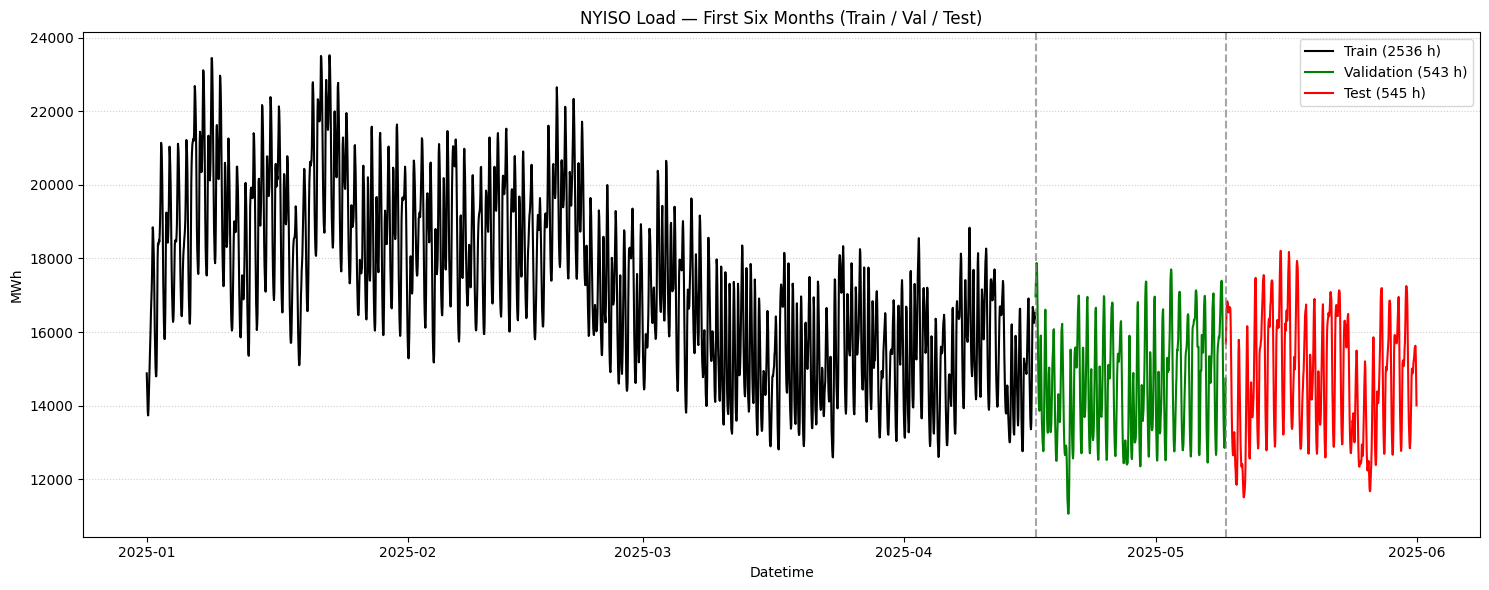


MegaWatts per Hour — First Six Months

Datetime
2025-01-01 00:00:00    14877.0
2025-01-01 01:00:00    14487.0
2025-01-01 02:00:00    14091.0
2025-01-01 03:00:00    13804.0
2025-01-01 04:00:00    13735.0
2025-01-01 05:00:00    13929.0
Freq: h, Name: NYISO_Load, dtype: float64
....
Datetime
2025-05-31 18:00:00    15571.0
2025-05-31 19:00:00    15610.0
2025-05-31 20:00:00    15628.0
2025-05-31 21:00:00    15342.0
2025-05-31 22:00:00    14727.0
2025-05-31 23:00:00    14007.0
Freq: h, Name: NYISO_Load, dtype: float64
Length: 3624 hours


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --------------------------
# 0) Load & reshape (Hr1..Hr24 only)
# --------------------------
df = pd.read_csv("/content/drive/MyDrive/nyiso_loads.csv")

# strictly keep Hr1..Hr24 (drop Hr25 if present)
hour_cols = sorted(
    [c for c in df.columns if re.fullmatch(r"Hr\d+", c) and 1 <= int(c[2:]) <= 24],
    key=lambda c: int(c[2:])
)

# wide -> long (1 row per hour)
long_df = df.melt(
    id_vars=["Year", "Month", "Day"],
    value_vars=hour_cols,
    var_name="Hour",
    value_name="Load"
).sort_values(["Year", "Month", "Day", "Hour"], ignore_index=True)

# datetime index
long_df["Datetime"] = (
    pd.to_datetime(long_df[["Year", "Month", "Day"]]) +
    pd.to_timedelta(long_df["Hour"].str.extract(r"(\d+)").astype(int)[0] - 1, unit="h")
)
long_df = long_df.sort_values("Datetime", ignore_index=True)

# series
load_series = pd.Series(long_df["Load"].values, index=long_df["Datetime"], name="NYISO_Load")
load_series.index.name = "Datetime"

# --------------------------
# 1) Keep ONLY the first six months from the series start
# --------------------------
start = load_series.index.min().normalize()
end   = start + pd.DateOffset(months=5)   # exclusive upper bound
s6    = load_series.loc[(load_series.index >= start) & (load_series.index < end)].copy()

# Enforce hourly cadence & light gap fill
s6 = s6.asfreq('h')             # pandas now prefers lowercase 'h'
s6 = s6.interpolate(limit=3)    # fill gaps up to 3 hours
s6 = s6.dropna()

print(f"Window kept: {s6.index[0]}  →  {s6.index[-1]}  ({len(s6)} hours)")

# --------------------------
# 2) Chronological split: 70% / 15% / 15%
# --------------------------
N       = len(s6)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

idx_tr = slice(0, n_train)
idx_va = slice(n_train, n_train + n_val)
idx_te = slice(n_train + n_val, N)

t_train_end = s6.index[n_train]
t_val_end   = s6.index[n_train + n_val]

print(f"Split sizes — train: {n_train}, val: {n_val}, test: {n_test}")

# --------------------------
# 3) Plot Train / Val / Test
# --------------------------
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(s6.index[idx_tr], s6.values[idx_tr], color='black', label=f"Train ({n_train} h)")
ax.plot(s6.index[idx_va], s6.values[idx_va], color='green', label=f"Validation ({n_val} h)")
ax.plot(s6.index[idx_te], s6.values[idx_te], color='red',   label=f"Test ({n_test} h)")

ax.axvline(t_train_end, linestyle='--', color='gray', alpha=0.7)
ax.axvline(t_val_end,   linestyle='--', color='gray', alpha=0.7)

ax.set_title("NYISO Load — First Six Months (Train / Val / Test)")
ax.set_xlabel("Datetime")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 4) Quick peek & NumPy export
# --------------------------
print("\nMegaWatts per Hour — First Six Months\n")
print(s6.head(6))
print('....')
print(s6.tail(6))
print(f"Length: {len(s6)} hours")

# For RNN/LSTM training
load_array = s6.to_numpy().astype(np.float32)


#### Plot Last Two Weeks

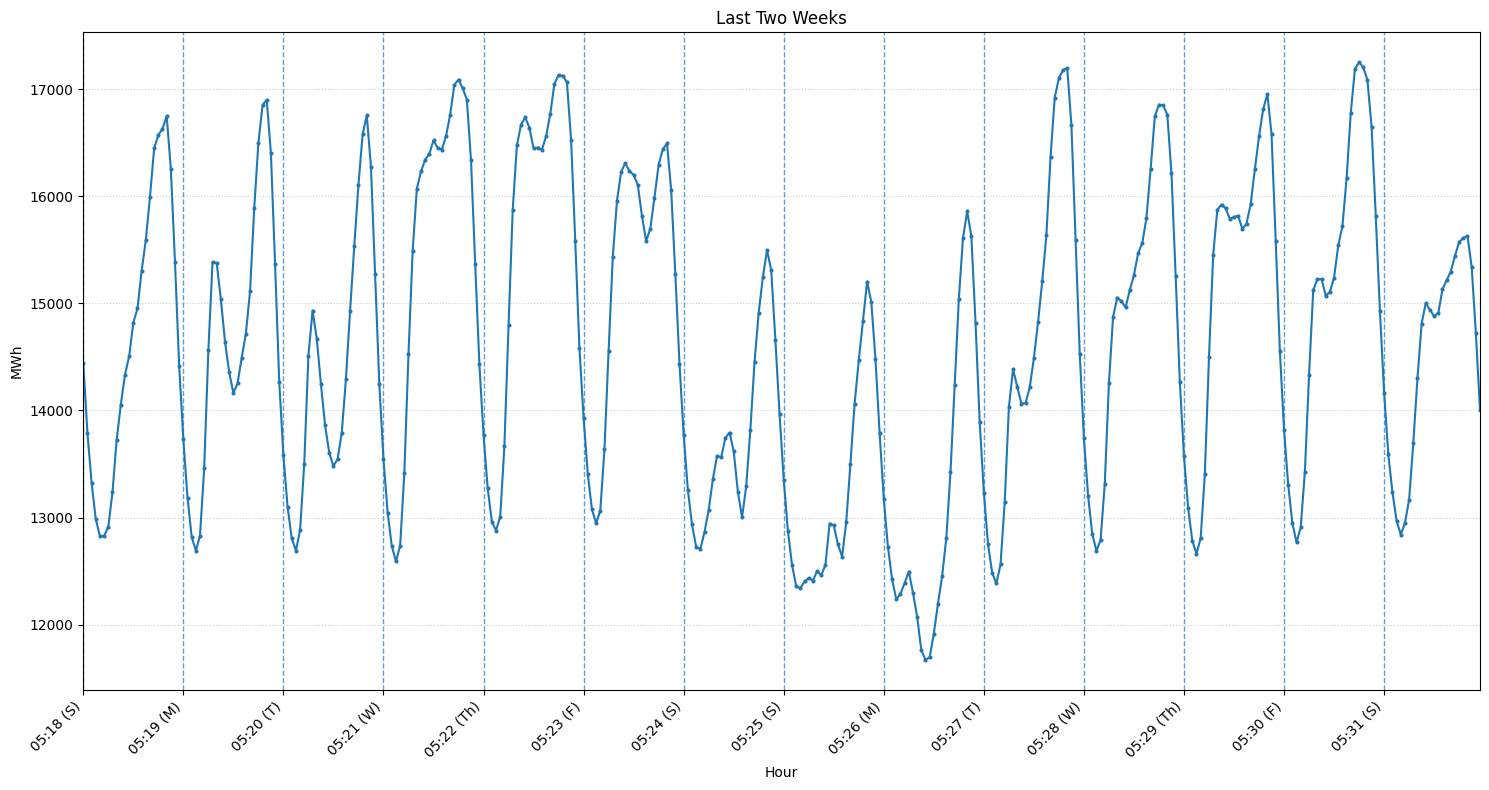

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Choose the series to plot (use s6 if you limited to first six months)
series = s6    # or load_series

period_hours = 24 * 14
sel = series.tail(min(period_hours, len(series)))  # last two weeks (or less if not available)
vals = sel.values

# positions of midnights within the selection
midnight_mask = sel.index.hour == 0
day_positions = np.nonzero(midnight_mask)[0]
day_times = sel.index[midnight_mask]

# weekday letter: Mon=M, Tue=T, Wed=W, Thu=Th, Fri=F, Sat/Sun=S
def wd_letter(ts: pd.Timestamp) -> str:
    dow = ts.dayofweek  # Mon=0 ... Sun=6
    if dow >= 5:
        return "S"
    return ["M", "T", "W", "Th", "F"][dow]

day_labels = [f"{t:%m}:{t:%d} ({wd_letter(t)})" for t in day_times]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Last Two Weeks")
ax.plot(vals)
ax.scatter(range(len(vals)), vals, marker='.', s=15)

# vertical lines at each midnight
for x in day_positions:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlim(0, len(vals) - 1)
ax.set_xlabel("Hour")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)

ax.set_xticks(day_positions)
ax.set_xticklabels(day_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Preprocess Data into Sliding Windows


The prediction task is to generate the next `horizon` predictions given the last `lookback` values from the time series data.  

> Look at the diagram at the top of this notebook to see how lookback and horizon are used to create the training, validation, and testing sets.

**Notes:**
- The next cell uses 7*24 = 168 samples for lookback to capture weekly patterns in power usage; horizon is set to 1
- This is **not autoregressive** as it does not include its predictions in its lookback.
- Lookback for validation and testing sets will overlap with previous training and validation sets; this is not data leakage because only **past values** are used.
- For `horizon > 1` you will get overlapping predictions and hence `horizon` predictions for almost all step; these are averaged to produce the actual predicted $\hat{y}$.

In [23]:
# assume s6 exists (your Jan–Jun hourly Series), and you computed n_train, n_val
train = s6.iloc[:n_train]
val   = s6.iloc[n_train:n_train+n_val]
test  = s6.iloc[n_train+n_val:]

# --------------------------
# 3) Scaling (fit on train only)
# --------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
val_x   = scaler.transform(val.values.reshape(-1,1)).astype(np.float32)
test_x  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)

# --------------------------
# 4) Windowing utility
# lookback = number of past hours used as features
# horizon  = 1 (predict next hour)
# --------------------------
def make_windows(arr, lookback=168, horizon=1):
    X, y = [], []
    for i in range(lookback, len(arr)-horizon+1):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i:i+horizon, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # shapes: X -> (samples, lookback), y -> (samples, horizon)
    return X[..., None], y  # add feature dim -> (samples, lookback, 1)

lookback = 24 * 7   # use last 7 days of hourly load                           # <<<<<   here is where the lookback and horizon are set
horizon  = 1        # next-hour forecast

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x,   lookback, horizon)
X_test, y_test = make_windows(test_x,  lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_test:", y_test.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes:
  X_train: (2368, 168, 1) y_test: (377, 1)
  X_val: (375, 168, 1) y_val: (375, 1)
  X_test: (377, 168, 1) y_test: (377, 1)


### Build a Baseline LSTM Model for lookback = 2 weeks, horizon = next hour


Baseline Model

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8835 - mae: 0.7592 - rmse: 0.9343 - val_loss: 0.3210 - val_mae: 0.4924 - val_rmse: 0.5666
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3932 - mae: 0.5314 - rmse: 0.6266 - val_loss: 0.2912 - val_mae: 0.4565 - val_rmse: 0.5397
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3031 - mae: 0.4679 - rmse: 0.5502 - val_loss: 0.2134 - val_mae: 0.3837 - val_rmse: 0.4620
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2407 - mae: 0.4114 - rmse: 0.4901 - val_loss: 0.1478 - val_mae: 0.3209 - val_rmse: 0.3844
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1741 - mae: 0.3456 - rmse: 0.4168 - val_loss: 0.1061 - val_mae: 0.2753 - val_rmse: 0.3258
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1203 - mae: 0.2817 - rmse: 0.3468 - val_loss: 0.0700 - val_mae: 0.2287 - val_rmse: 0.2645
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0963 - mae: 0.24

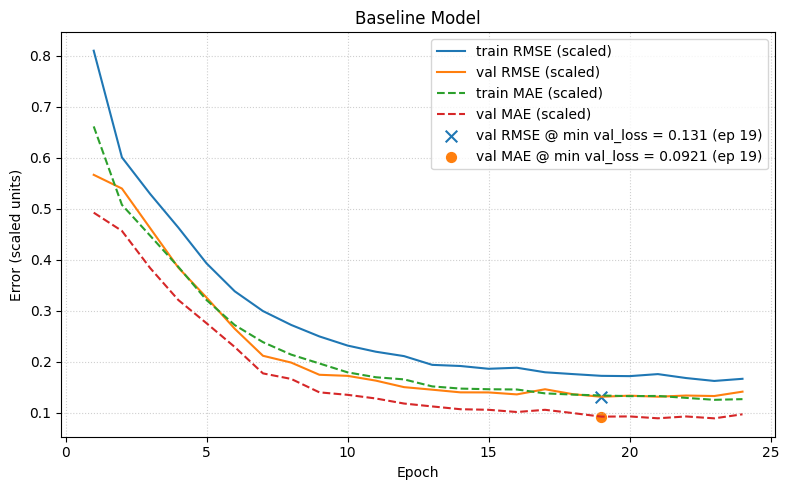

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.09209 | RMSE: 0.1311 (scaled)
Train @ sel —  MAE: 0.1335  | RMSE: 0.1721 (scaled)


In [24]:
# Baseline LSTM model

hn = keras.initializers.HeNormal(seed=random_seed)

baseline_model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=hn),
    Dense(horizon)
])


train_and_test( baseline_model,title="Baseline Model",verbose=1)

### Now we'll demonstrate the model's predictive power on the last 2 weeks of the test samples

Test RMSE (avg over all steps): 0.097 (scaled)
Test  MAE (avg over all steps): 0.081 (scaled)


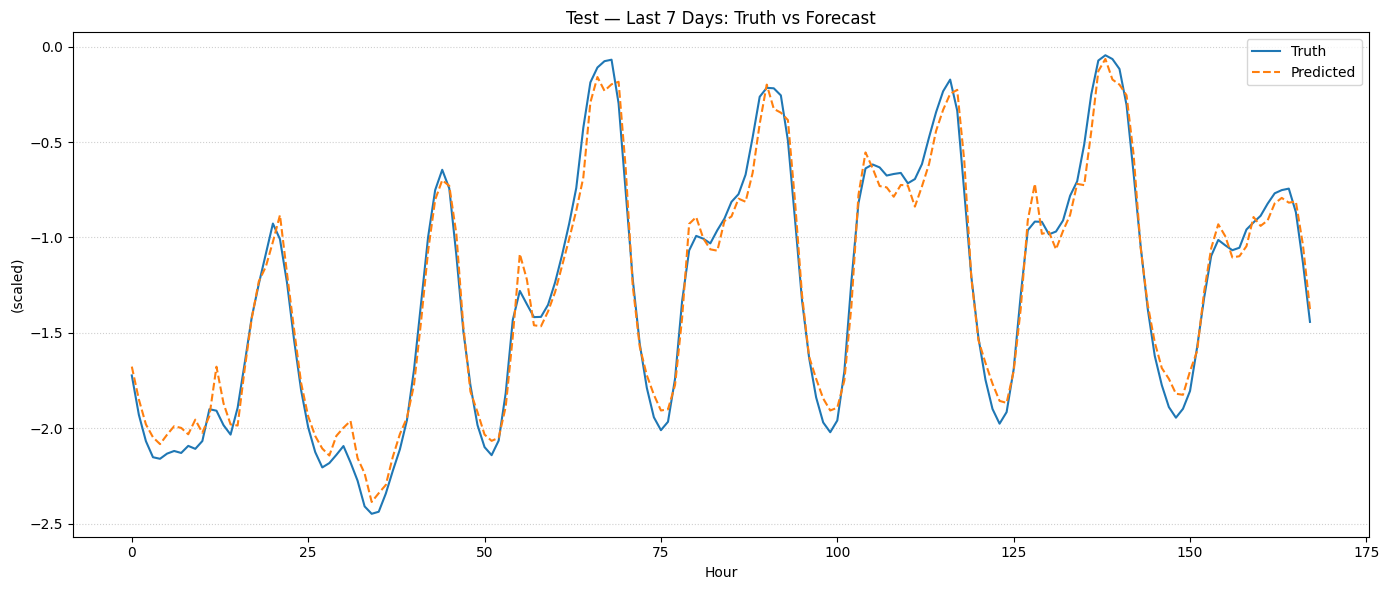

In [25]:
def evaluate_on_test(
    model,
    *,
    target_scaler=None,          # pass your y scaler here if you want original units
    report_in_scaled=True,       # set False to invert to original units
    unit_scaled="(scaled)",
    unit_original="MW",          # or "MWh" if your target is energy, not power
    plot_last_hours=24*7,
):
    """
    Evaluate on X_test/y_test and plot the last `plot_last_hours` predictions.
    Supports horizon=1 and direct multi-output (H>1).
    """
    # 1) Predict
    y_pred = model.predict(X_test, verbose=0)         # (n_windows, H) or (n_windows, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]
    H = y_pred.shape[1]

    # 2) Choose units (scaled vs original)
    def maybe_invert(arr):
        if report_in_scaled or target_scaler is None:
            return arr
        a = np.asarray(arr).reshape(-1, 1)
        return target_scaler.inverse_transform(a).ravel()

    # 3) Build comparable arrays for metrics
    # y_test matches y_pred shape: (n_windows, H)
    y_true = y_test
    # Metrics (per-horizon and averaged) in chosen units
    err = maybe_invert(y_pred.ravel()) - maybe_invert(y_true.ravel())
    rmse_avg = float(np.sqrt(np.mean(err**2)))
    mae_avg  = float(np.mean(np.abs(err)))

    if H > 1:
        # per-horizon
        y_true_u = maybe_invert(y_true)
        y_pred_u = maybe_invert(y_pred)
        mae_per_h  = np.mean(np.abs(y_true_u - y_pred_u), axis=0)
        rmse_per_h = np.sqrt(np.mean((y_true_u - y_pred_u)**2, axis=0))

    # 4) Prepare a single timeline for plotting
    def stitch_direct_predictions(yhat):
        """Average overlaps for direct multi-step predictions."""
        n, HH = yhat.shape
        total = n + HH - 1
        out = np.zeros(total, dtype=float)
        cnt = np.zeros(total, dtype=float)
        for i in range(n):
            out[i:i+HH] += yhat[i]
            cnt[i:i+HH] += 1.0
        return out / np.maximum(cnt, 1.0)

    # Choose units for plotting
    unit = unit_scaled if (report_in_scaled or target_scaler is None) else unit_original

    if H == 1:
        y_true_t = maybe_invert(y_true.ravel())
        y_pred_t = maybe_invert(y_pred.ravel())
    else:
        # stitch both for a continuous timeline
        y_pred_t = stitch_direct_predictions(maybe_invert(y_pred))
        y_true_t = stitch_direct_predictions(maybe_invert(y_true))

    # 5) Print summary
    print(f"Test RMSE (avg over all steps): {rmse_avg:,.3f} {unit}")
    print(f"Test  MAE (avg over all steps): {mae_avg:,.3f} {unit}")
    if H > 1:
        print("Per-horizon (0 = 1-step ahead):")
        print("  MAE :", np.round(mae_per_h, 3))
        print("  RMSE:", np.round(rmse_per_h, 3))

    # 6) Plot last N hours
    N = min(plot_last_hours, len(y_true_t))
    plt.figure(figsize=(14, 6))
    plt.title("Test — Last 7 Days: Truth vs Forecast")
    plt.plot(y_true_t[-N:], label="Truth")
    plt.plot(y_pred_t[-N:], label="Predicted", linestyle="--")
    plt.xlabel("Hour")
    plt.ylabel(unit)
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_on_test(baseline_model)

## Problem One — Exploring Lookback and Horizon

Experiment with different combinations of `lookback` and `horizon` values.  
For example, you might double the lookback window (e.g., from 1 week to 2 weeks) or extend the prediction horizon to 24 hours.  

After each change:
- Retrain your model.
- Use `evaluate_on_test(...)` to visualize the extended 2-week prediction.
- Compare validation and test MAE/RMSE across experiments.
- Answer the graded questions.

> *Note:* You’ll need to adjust the data-preparation cell above to rebuild the training, validation, and testing sets with the new parameters.



LB=72h, H=1h — LSTM(32)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6765 - mae: 0.6728 - rmse: 0.8192 - val_loss: 0.3420 - val_mae: 0.5047 - val_rmse: 0.5848 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3299 - mae: 0.4932 - rmse: 0.5743 - val_loss: 0.2949 - val_mae: 0.4618 - val_rmse: 0.5431 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2638 - mae: 0.4371 - rmse: 0.5134 - val_loss: 0.2477 - val_mae: 0.4202 - val_rmse: 0.4977 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1929 - mae: 0.3660 - rmse: 0.4389 - val_loss: 0.1671 - val_mae: 0.3484 - val_rmse: 0.4088 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1328 - mae: 0.2971 - rmse: 0.3644 - val_loss: 0.1191 - val_mae: 0.2927 - val_rmse: 0.3451 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1053 - mae: 0.2620 - rmse: 0.3245 - val_lo

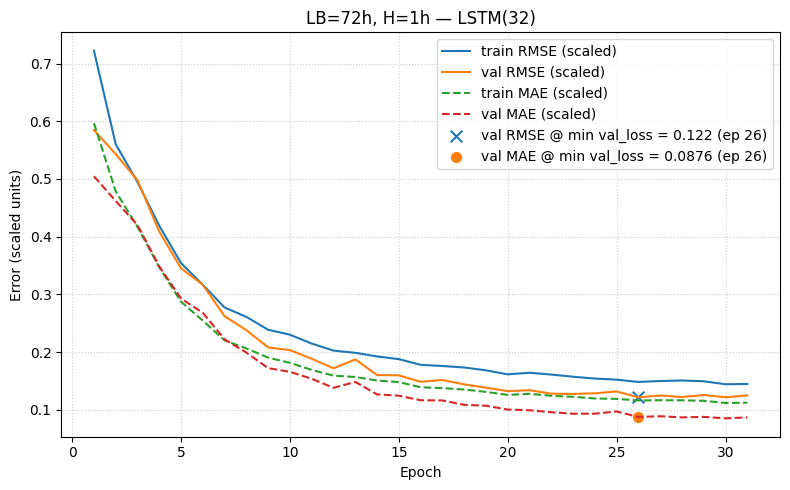

Selected epoch: 26 (min val_loss)
Valid @ sel —  MAE: 0.08756 | RMSE: 0.1215 (scaled)
Train @ sel —  MAE: 0.1161  | RMSE: 0.1482 (scaled)
Test RMSE (avg over all steps): 0.096 (scaled)
Test  MAE (avg over all steps): 0.079 (scaled)


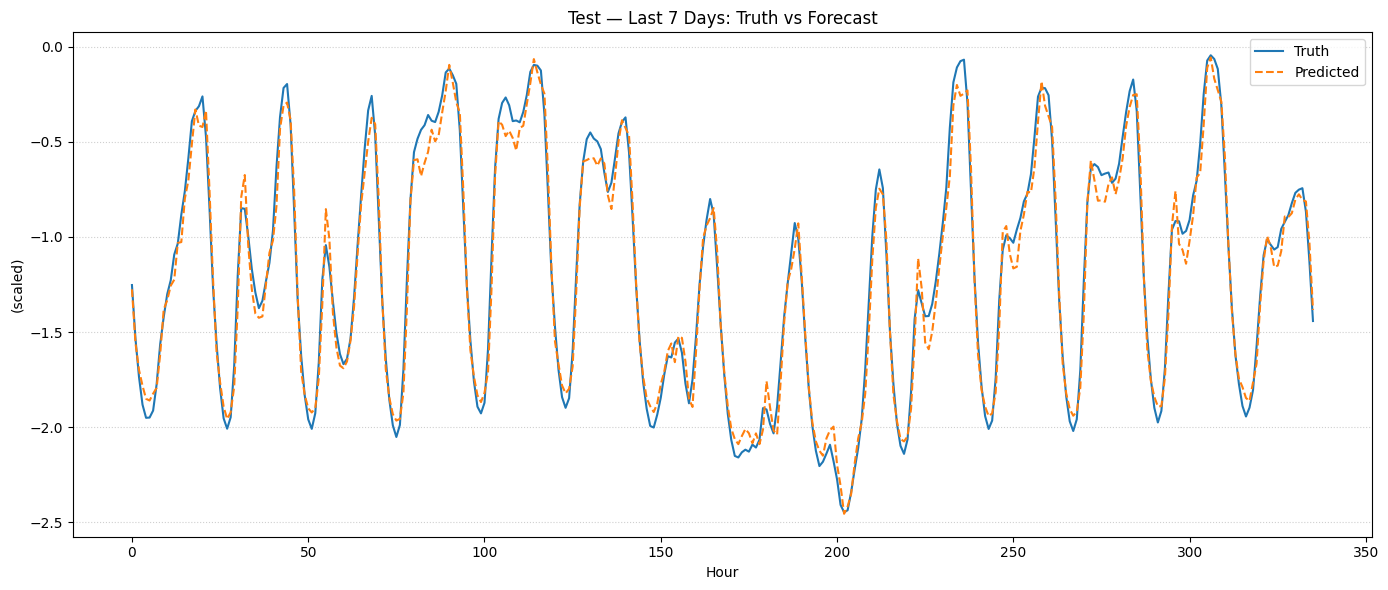


LB=168h, H=1h — LSTM(32)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.7777 - mae: 0.7138 - rmse: 0.8778 - val_loss: 0.3487 - val_mae: 0.5055 - val_rmse: 0.5905 - learning_rate: 0.0010
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4068 - mae: 0.5389 - rmse: 0.6375 - val_loss: 0.3240 - val_mae: 0.4805 - val_rmse: 0.5692 - learning_rate: 0.0010
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3404 - mae: 0.4970 - rmse: 0.5829 - val_loss: 0.2727 - val_mae: 0.4430 - val_rmse: 0.5222 - learning_rate: 0.0010
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2608 - mae: 0.4309 - rmse: 0.5100 - val_loss: 0.2140 - val_mae: 0.3910 - val_rmse: 0.4626 - learning_rate: 0.0010
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1906 - mae: 0.3608 - rmse: 0.4361 - val_loss: 0.1280 - val_mae: 0.3085 - val_rmse: 0.3577 - learning_rate: 0.0010
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1233 - mae: 0.2854 - rmse: 0.3510 - v

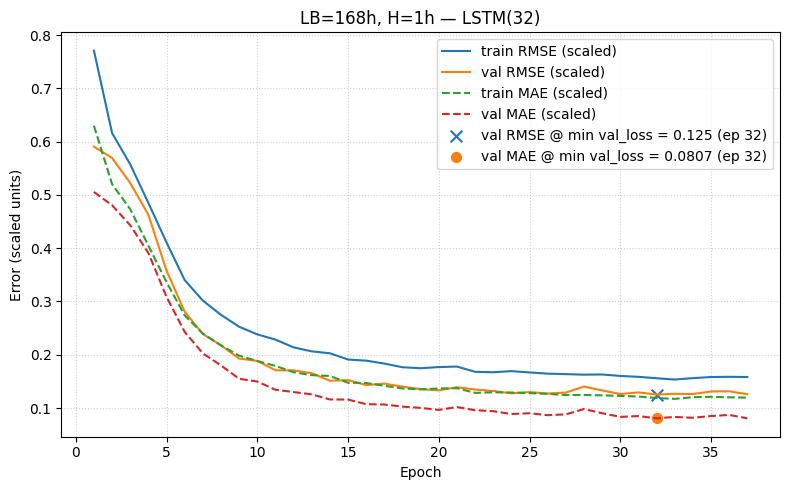

Selected epoch: 32 (min val_loss)
Valid @ sel —  MAE: 0.08074 | RMSE: 0.1253 (scaled)
Train @ sel —  MAE: 0.1188  | RMSE: 0.156 (scaled)
Test RMSE (avg over all steps): 0.085 (scaled)
Test  MAE (avg over all steps): 0.069 (scaled)


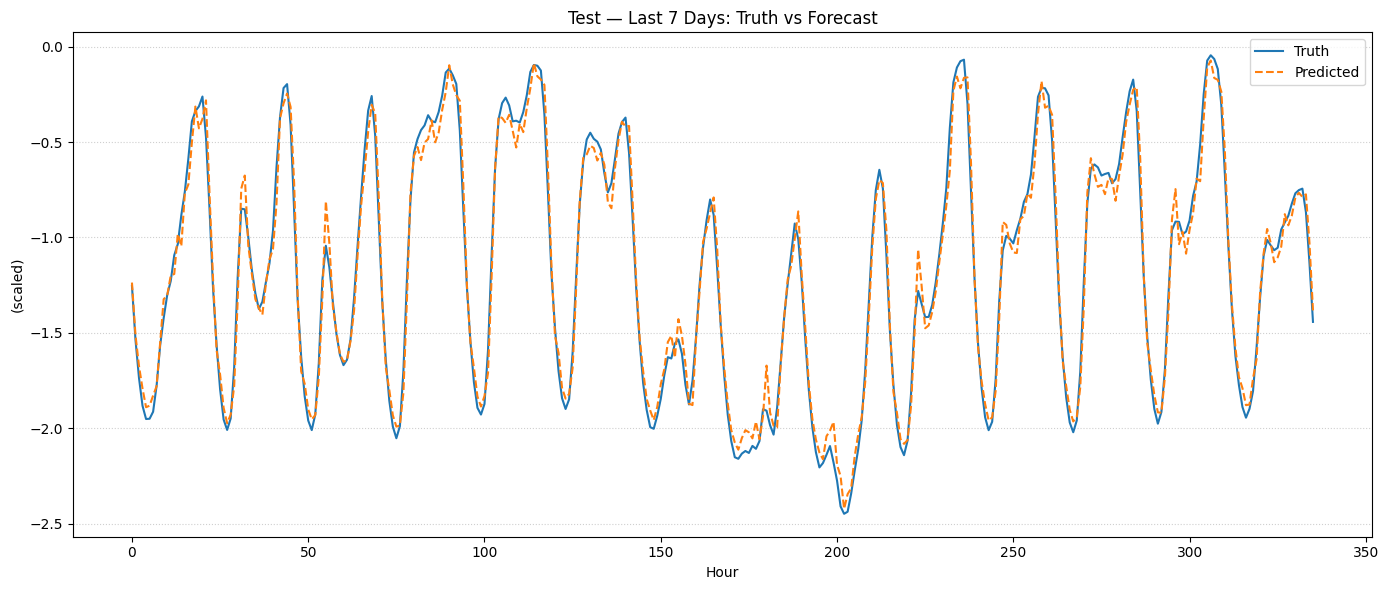


LB=336h, H=1h — LSTM(32)

Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7893 - mae: 0.7301 - rmse: 0.8856 - val_loss: 0.3554 - val_mae: 0.4973 - val_rmse: 0.5961 - learning_rate: 0.0010
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3983 - mae: 0.5380 - rmse: 0.6309 - val_loss: 0.3153 - val_mae: 0.4574 - val_rmse: 0.5615 - learning_rate: 0.0010
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3419 - mae: 0.5010 - rmse: 0.5845 - val_loss: 0.2640 - val_mae: 0.4191 - val_rmse: 0.5138 - learning_rate: 0.0010
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2851 - mae: 0.4563 - rmse: 0.5336 - val_loss: 0.2092 - val_mae: 0.3690 - val_rmse: 0.4574 - learning_rate: 0.0010
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2209 - mae: 0.3987 - rmse: 0.4698 - val_loss: 0.1499 - val_mae: 0.3128 - val_rmse: 0.3872 - learning_rate: 0.0010
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1531 - mae: 0.3236 - rmse: 0.3911 - v

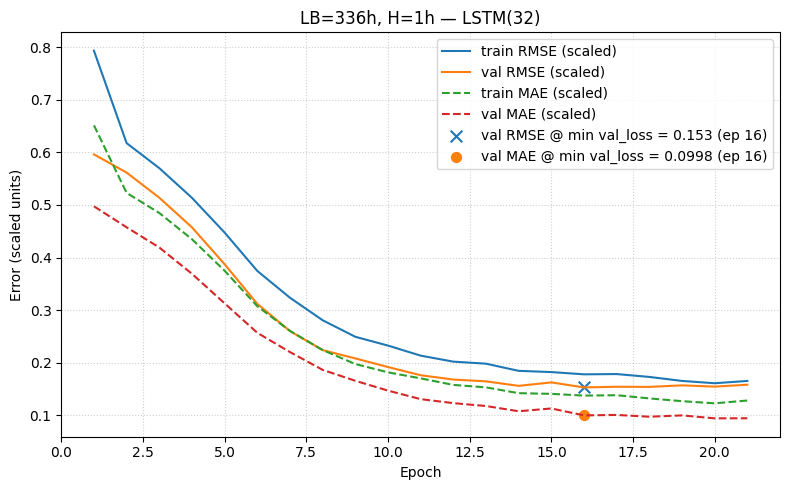

Selected epoch: 16 (min val_loss)
Valid @ sel —  MAE: 0.09978 | RMSE: 0.1529 (scaled)
Train @ sel —  MAE: 0.1373  | RMSE: 0.1778 (scaled)
Test RMSE (avg over all steps): 0.109 (scaled)
Test  MAE (avg over all steps): 0.090 (scaled)


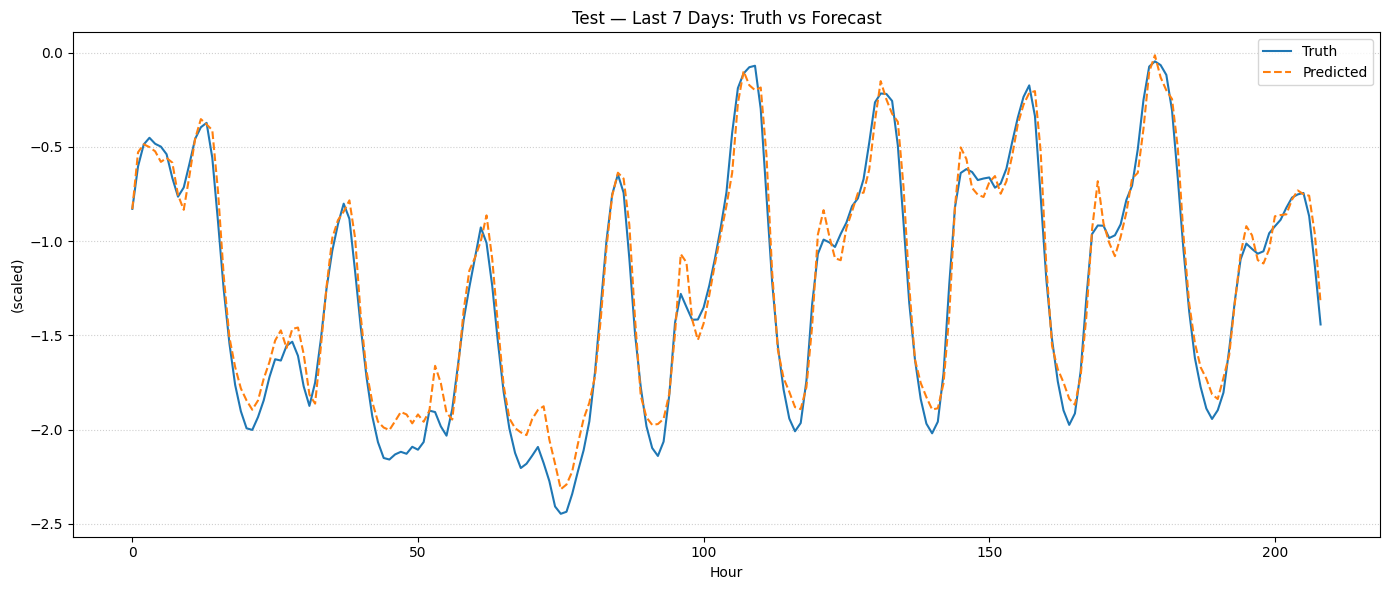


LB=168h, H=6h — LSTM(48)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9157 - mae: 0.7922 - rmse: 0.9562 - val_loss: 0.7743 - val_mae: 0.7197 - val_rmse: 0.8799 - learning_rate: 0.0010
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5378 - mae: 0.6092 - rmse: 0.7332 - val_loss: 0.4873 - val_mae: 0.5833 - val_rmse: 0.6981 - learning_rate: 0.0010
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4823 - mae: 0.5803 - rmse: 0.6944 - val_loss: 0.4793 - val_mae: 0.5786 - val_rmse: 0.6923 - learning_rate: 0.0010
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4472 - mae: 0.5606 - rmse: 0.6686 - val_loss: 0.4530 - val_mae: 0.5647 - val_rmse: 0.6731 - learning_rate: 0.0010
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4054 - mae: 0.5333 - rmse: 0.6366 - val_loss: 0.4483 - val_mae: 0.5608 - val_rmse: 0.6695 - learning_rate: 0.0010
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3385 - mae: 0.4832 - rmse: 0.5817 - v

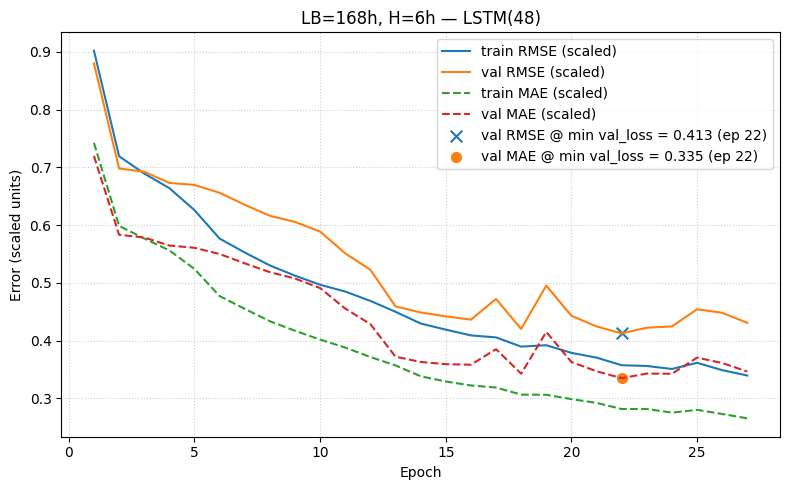

Selected epoch: 22 (min val_loss)
Valid @ sel —  MAE: 0.3352 | RMSE: 0.4127 (scaled)
Train @ sel —  MAE: 0.2818  | RMSE: 0.3576 (scaled)
Test RMSE (avg over all steps): 0.424 (scaled)
Test  MAE (avg over all steps): 0.339 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.188 0.274 0.326 0.374 0.442 0.431]
  RMSE: [0.229 0.334 0.392 0.449 0.536 0.522]


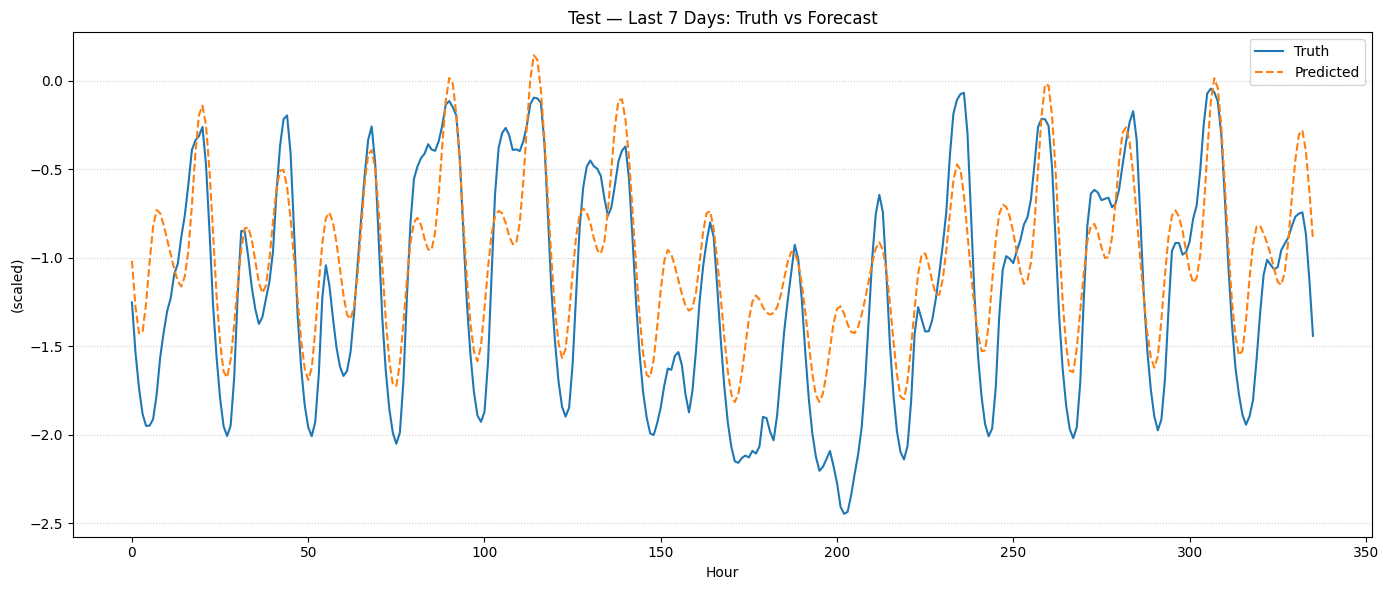


LB=168h, H=24h — LSTM(64)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9149 - mae: 0.7856 - rmse: 0.9560 - val_loss: 1.0425 - val_mae: 0.8226 - val_rmse: 1.0210 - learning_rate: 0.0010
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6435 - mae: 0.6506 - rmse: 0.8019 - val_loss: 0.7383 - val_mae: 0.6874 - val_rmse: 0.8592 - learning_rate: 0.0010
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4770 - mae: 0.5637 - rmse: 0.6905 - val_loss: 0.5741 - val_mae: 0.6192 - val_rmse: 0.7577 - learning_rate: 0.0010
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3991 - mae: 0.5191 - rmse: 0.6317 - val_loss: 0.4811 - val_mae: 0.5762 - val_rmse: 0.6936 - learning_rate: 0.0010
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3537 - mae: 0.4882 - rmse: 0.5947 - val_loss: 0.4182 - val_mae: 0.5413 - val_rmse: 0.6466 - learning_rate: 0.0010
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3212 - mae: 0.4656 - rmse: 0.5668 - 

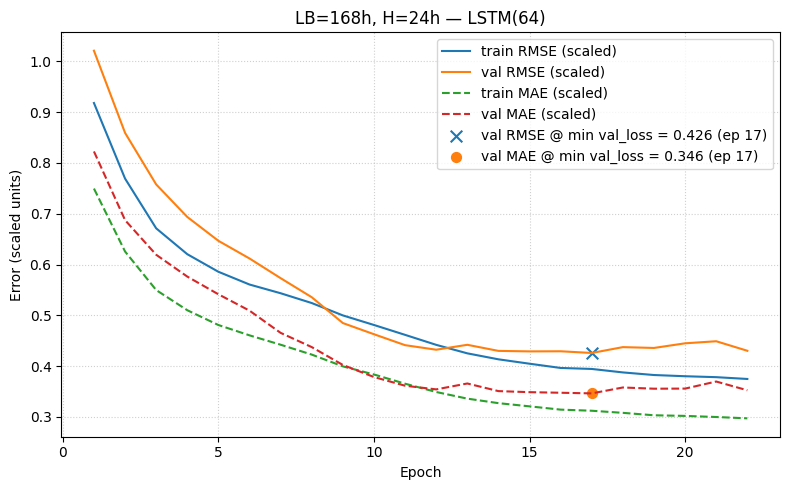

Selected epoch: 17 (min val_loss)
Valid @ sel —  MAE: 0.3462 | RMSE: 0.4258 (scaled)
Train @ sel —  MAE: 0.312  | RMSE: 0.3943 (scaled)
Test RMSE (avg over all steps): 0.461 (scaled)
Test  MAE (avg over all steps): 0.370 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.27  0.337 0.373 0.398 0.414 0.458 0.401 0.407 0.413 0.457 0.426 0.385
 0.359 0.352 0.349 0.342 0.351 0.357 0.354 0.374 0.326 0.331 0.305 0.344]
  RMSE: [0.356 0.44  0.462 0.496 0.497 0.551 0.484 0.494 0.492 0.538 0.509 0.472
 0.447 0.44  0.435 0.434 0.442 0.451 0.466 0.479 0.409 0.418 0.385 0.425]


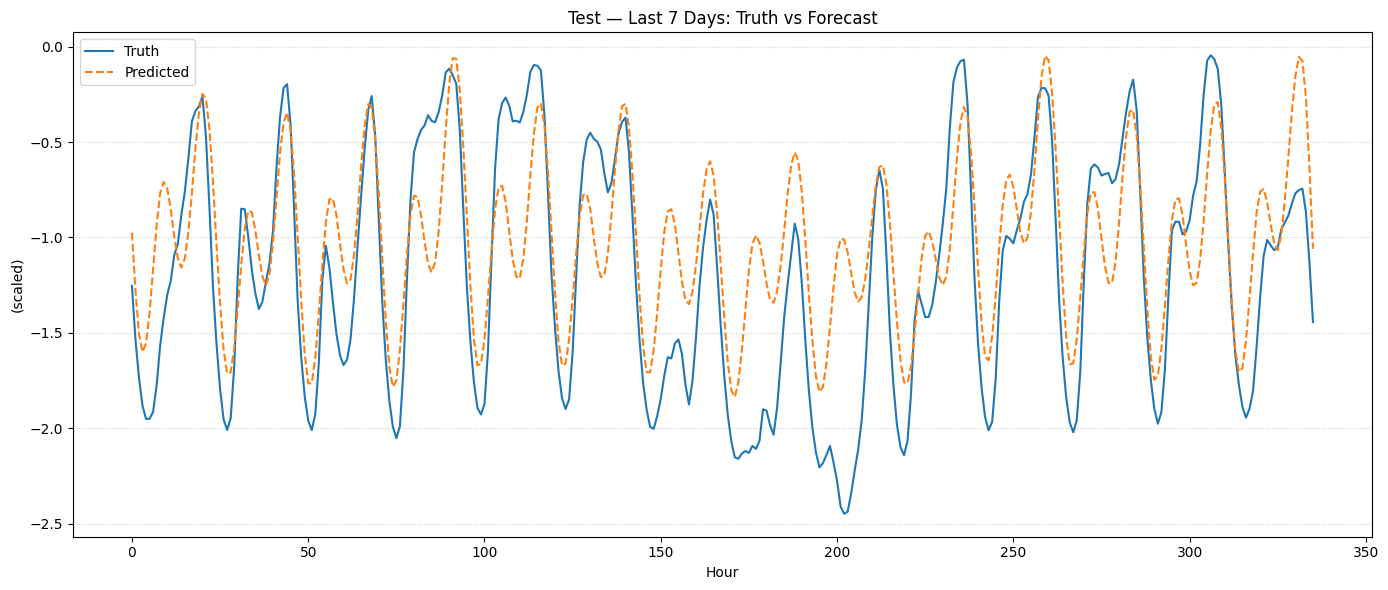


LB=336h, H=24h — LSTM(64)

Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.9024 - mae: 0.7818 - rmse: 0.9497 - val_loss: 0.8292 - val_mae: 0.7292 - val_rmse: 0.9106 - learning_rate: 0.0010
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6473 - mae: 0.6579 - rmse: 0.8043 - val_loss: 0.5296 - val_mae: 0.5898 - val_rmse: 0.7277 - learning_rate: 0.0010
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5027 - mae: 0.5862 - rmse: 0.7090 - val_loss: 0.4152 - val_mae: 0.5352 - val_rmse: 0.6444 - learning_rate: 0.0010
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4463 - mae: 0.5567 - rmse: 0.6680 - val_loss: 0.3886 - val_mae: 0.5217 - val_rmse: 0.6234 - learning_rate: 0.0010
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4213 - mae: 0.5414 - rmse: 0.6491 - val_loss: 0.3798 - val_mae: 0.5163 - val_rmse: 0.6163 - learning_rate: 0.0010
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3927 - mae: 0.5225 - rmse: 0.6266 - 

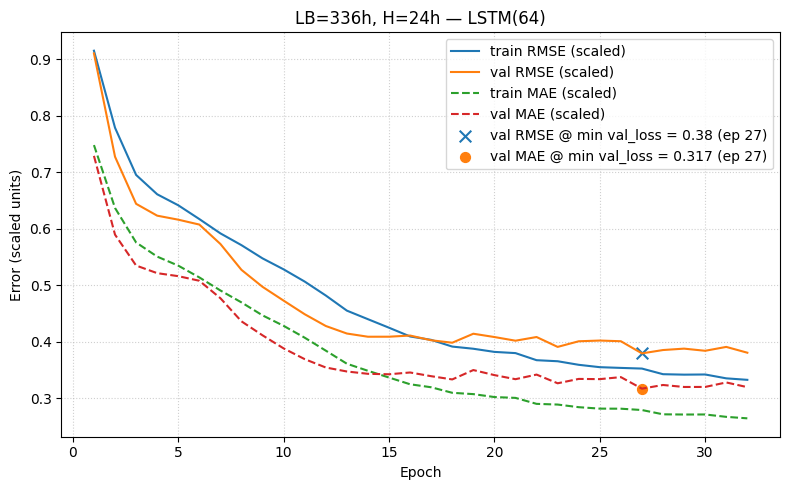

Selected epoch: 27 (min val_loss)
Valid @ sel —  MAE: 0.3173 | RMSE: 0.3797 (scaled)
Train @ sel —  MAE: 0.2794  | RMSE: 0.3528 (scaled)
Test RMSE (avg over all steps): 0.548 (scaled)
Test  MAE (avg over all steps): 0.431 (scaled)
Per-horizon (0 = 1-step ahead):
  MAE : [0.362 0.367 0.4   0.442 0.473 0.464 0.462 0.453 0.46  0.451 0.404 0.399
 0.402 0.414 0.489 0.457 0.452 0.467 0.472 0.453 0.458 0.393 0.379 0.374]
  RMSE: [0.463 0.472 0.515 0.566 0.611 0.583 0.594 0.575 0.578 0.556 0.507 0.513
 0.502 0.529 0.605 0.573 0.566 0.59  0.601 0.572 0.583 0.502 0.48  0.477]


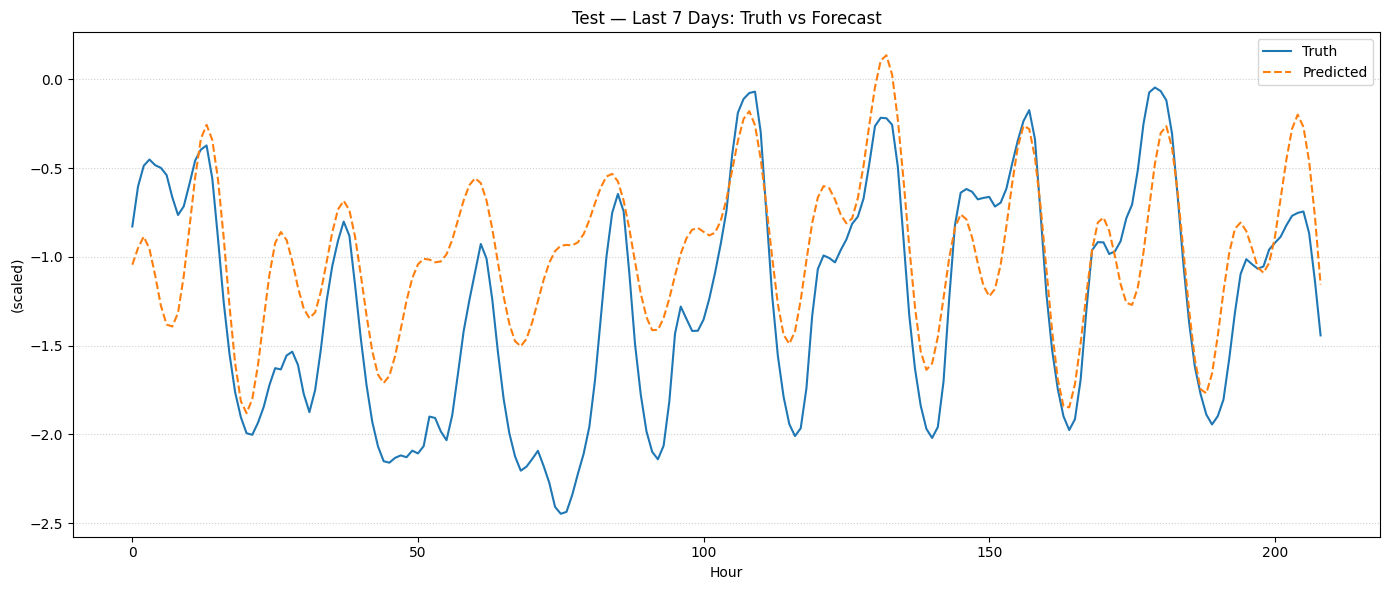


=== Leaderboard (by val_RMSE@min_val_loss; scaled units) ===
LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1529 | val_MAE@min_val_loss=0.09978 | epoch=16  (scaled)
LB=336h, H=24h — LSTM(64)            val_RMSE@min_val_loss=0.3797 | val_MAE@min_val_loss=0.3173 | epoch=27  (scaled)
LB=168h, H=6h — LSTM(48)             val_RMSE@min_val_loss=0.4127 | val_MAE@min_val_loss=0.3352 | epoch=22  (scaled)
LB=168h, H=24h — LSTM(64)            val_RMSE@min_val_loss=0.4258 | val_MAE@min_val_loss=0.3462 | epoch=17  (scaled)


In [26]:
# Your code here, add as many cells as you like


def build_lstm(horizon, lookback, *, units=32, dropout=0.2, seed=42):
    """Baseline LSTM that outputs `horizon` steps directly (non-autoregressive)."""
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(lookback, 1)),
        LSTM(units),
        Dropout(dropout),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(horizon)
    ])

def rebuild_windows(lookback, horizon):
    """Create windows for a given (lookback, horizon) using existing scaled splits."""
    X_tr, y_tr = make_windows(train_x, lookback, horizon)
    X_va, y_va = make_windows(val_x,   lookback, horizon)
    X_te, y_te = make_windows(test_x,  lookback, horizon)
    return X_tr, y_tr, X_va, y_va, X_te, y_te

def run_experiment(lookback, horizon, *, title=None, units=32, dropout=0.2, epochs=60, batch=64):
    """Train, plot curves, and visualize last-2-weeks forecast for one configuration."""
    if title is None:
        title = f"LB={lookback}h, H={horizon}h — LSTM({units})"

    # Window rebuild for this config
    X_tr, y_tr, X_va, y_va, X_te, y_te = rebuild_windows(lookback, horizon)

    # Expose to globals so train_and_test / evaluate_on_test can see them
    globals().update(dict(
        X_train=X_tr, y_train=y_tr,
        X_val=X_va,   y_val=y_va,
        X_test=X_te,  y_test=y_te
    ))

    model = build_lstm(horizon=horizon, lookback=lookback, units=units, dropout=dropout)

    history, test_metrics, info = train_and_test(
        model,
        epochs=epochs,
        batch_size=batch,
        title=title,
        verbose=1,
        callbacks=[reduce_lr],
        return_history=True,
        plot_scaled_curves=True,
    )

    # Visualize last two weeks
    evaluate_on_test(model, plot_last_hours=24*14)

    return {
        "title": title,
        "selected_epoch": info["selected_epoch"],
        "val_rmse@min_valloss": info["val_at_sel"]["rmse"],
        "val_mae@min_valloss": info["val_at_sel"]["mae"],
        "test_rmse": test_metrics.get("rmse_from_mse_loss", float("nan")),
        "test_mae": test_metrics.get("mae", float("nan")),
    }

experiments = [
    # Horizon = 1 (next hour), vary lookback
    dict(lookback=24*3,   horizon=1,  units=32),  # 3 days
    dict(lookback=24*7,   horizon=1,  units=32),  # 1 week (baseline)
    dict(lookback=24*14,  horizon=1,  units=32),  # 2 weeks

    # Horizon = 6 (next 6 hours direct)
    dict(lookback=24*7,   horizon=6,  units=48),

    # Horizon = 24 (next 24 hours direct)
    dict(lookback=24*7,   horizon=24, units=64),

    # Optional: longer memory for 24-h horizon
    dict(lookback=24*14,  horizon=24, units=64),
]

summaries = []
for cfg in experiments:
    title = f"LB={cfg['lookback']}h, H={cfg['horizon']}h — LSTM({cfg.get('units',32)})"
    out = run_experiment(**cfg, title=title, epochs=60, batch=64)
    summaries.append(out)

print("\n=== Leaderboard (by val_RMSE@min_val_loss; scaled units) ===")
print_results(sort_by="val_rmse_at_min_valloss")

### Graded Questions

In [27]:
print_results(sort_by="val_rmse_at_min_valloss")


LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1529 | val_MAE@min_val_loss=0.09978 | epoch=16  (scaled)
LB=336h, H=24h — LSTM(64)            val_RMSE@min_val_loss=0.3797 | val_MAE@min_val_loss=0.3173 | epoch=27  (scaled)
LB=168h, H=6h — LSTM(48)             val_RMSE@min_val_loss=0.4127 | val_MAE@min_val_loss=0.3352 | epoch=22  (scaled)
LB=168h, H=24h — LSTM(64)            val_RMSE@min_val_loss=0.4258 | val_MAE@min_val_loss=0.3462 | epoch=17  (scaled)


In [28]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse) for your best choices of lookback and horizon

a1a = 0.08756             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.0876


#### Question a1b: Describe below your experiments. What effect did your changes to the lookback and horizon have? Did you get an improvement in the validation MAE?  

#### Your Answer Here:

Increasing the lookback from 3 days to 1 week helped since it captured weekly patterns, but 2 weeks didn’t add much and slightly hurt performance. Longer horizons (6–24 h) made errors grow, as expected. The best model was with a 72 h lookback and 1 h horizon, giving the lowest validation MAE (0.0876), a small improvement over the baseline.

## Problem Two — Architectural Tweaks

Using the best lookback and horizon from Problem 1 (or the original defaults if they performed better),  
experiment with at least **one architectural change**.  

Possible options:
- Add a deeper “head” (e.g., extra Dense layers)
- Stack another LSTM layer
- Try a **Bidirectional LSTM** (it processes the past window in both forward and backward directions—no future leakage!)

Train, evaluate, and answer the graded questions.  



P2 — Baseline LSTM (LB=72h, H=1h)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7997 - mae: 0.7271 - rmse: 0.8911 - val_loss: 0.4156 - val_mae: 0.5402 - val_rmse: 0.6446 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4070 - mae: 0.5456 - rmse: 0.6379 - val_loss: 0.3460 - val_mae: 0.4951 - val_rmse: 0.5882 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3396 - mae: 0.4928 - rmse: 0.5826 - val_loss: 0.2878 - val_mae: 0.4489 - val_rmse: 0.5364 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2460 - mae: 0.4189 - rmse: 0.4959 - val_loss: 0.2401 - val_mae: 0.4028 - val_rmse: 0.4900 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1895 - mae: 0.3621 - rmse: 0.4352 - val_loss: 0.1680 - val_mae: 0.3433 - val_rmse: 0.4098 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1539 - mae: 0.3197 - rmse: 0.3921

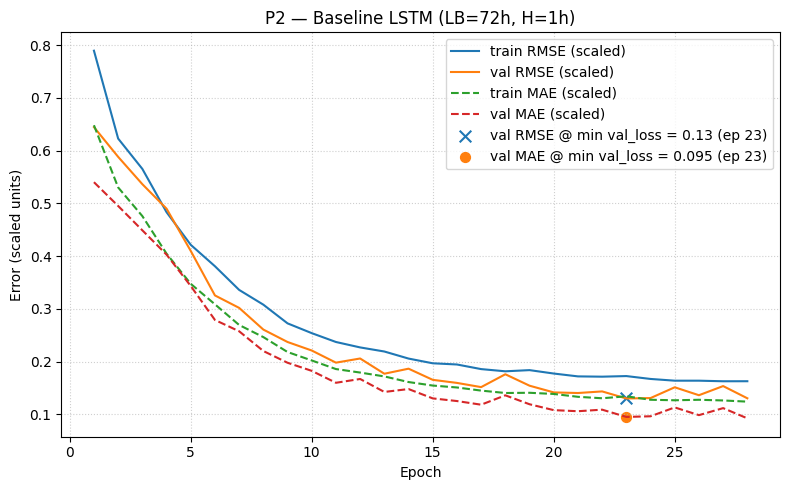

Selected epoch: 23 (min val_loss)
Valid @ sel —  MAE: 0.09501 | RMSE: 0.13 (scaled)
Train @ sel —  MAE: 0.1341  | RMSE: 0.1725 (scaled)
Test RMSE (avg over all steps): 0.104 (scaled)
Test  MAE (avg over all steps): 0.086 (scaled)


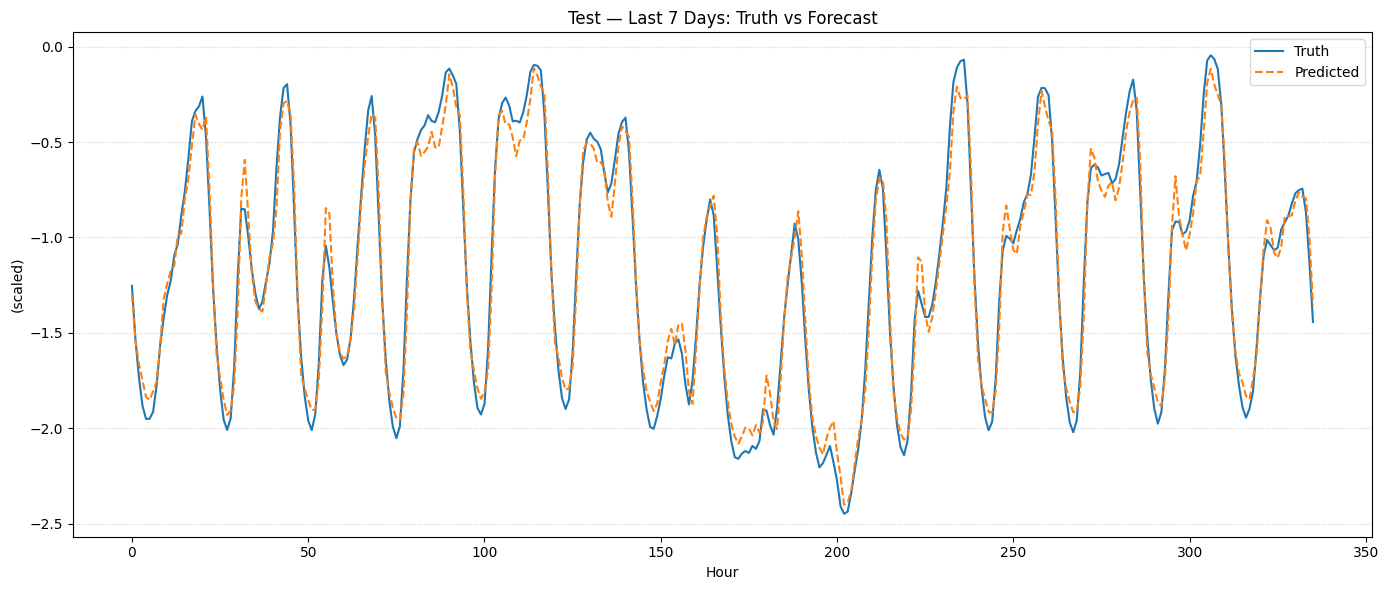


P2 — Deeper Head (Dense×2) (LB=72h, H=1h)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.7431 - mae: 0.6983 - rmse: 0.8594 - val_loss: 0.3820 - val_mae: 0.5060 - val_rmse: 0.6180 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3304 - mae: 0.4864 - rmse: 0.5745 - val_loss: 0.2639 - val_mae: 0.4252 - val_rmse: 0.5137 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2139 - mae: 0.3889 - rmse: 0.4622 - val_loss: 0.1732 - val_mae: 0.3481 - val_rmse: 0.4162 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1422 - mae: 0.3066 - rmse: 0.3768 - val_loss: 0.1105 - val_mae: 0.2856 - val_rmse: 0.3324 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1023 - mae: 0.2601 - rmse: 0.3197 - val_loss: 0.0885 - val_mae: 0.2536 - val_rmse: 0.2975 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0824 - mae: 0.2281 -

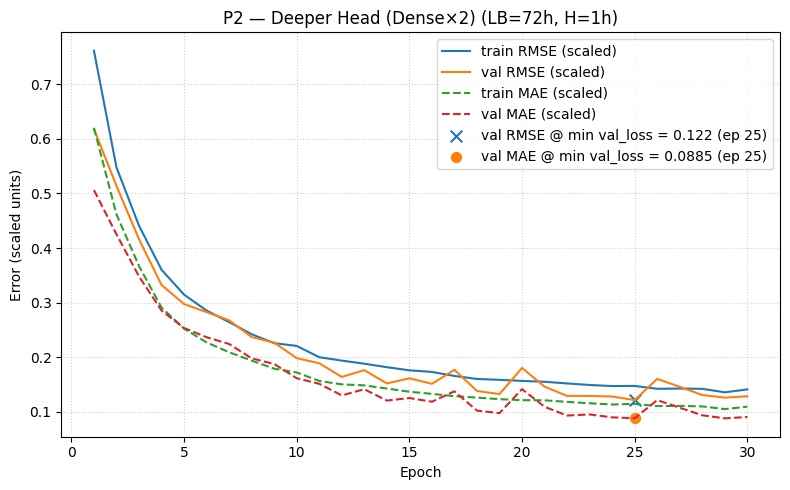

Selected epoch: 25 (min val_loss)
Valid @ sel —  MAE: 0.08847 | RMSE: 0.1217 (scaled)
Train @ sel —  MAE: 0.1147  | RMSE: 0.1476 (scaled)
Test RMSE (avg over all steps): 0.095 (scaled)
Test  MAE (avg over all steps): 0.080 (scaled)


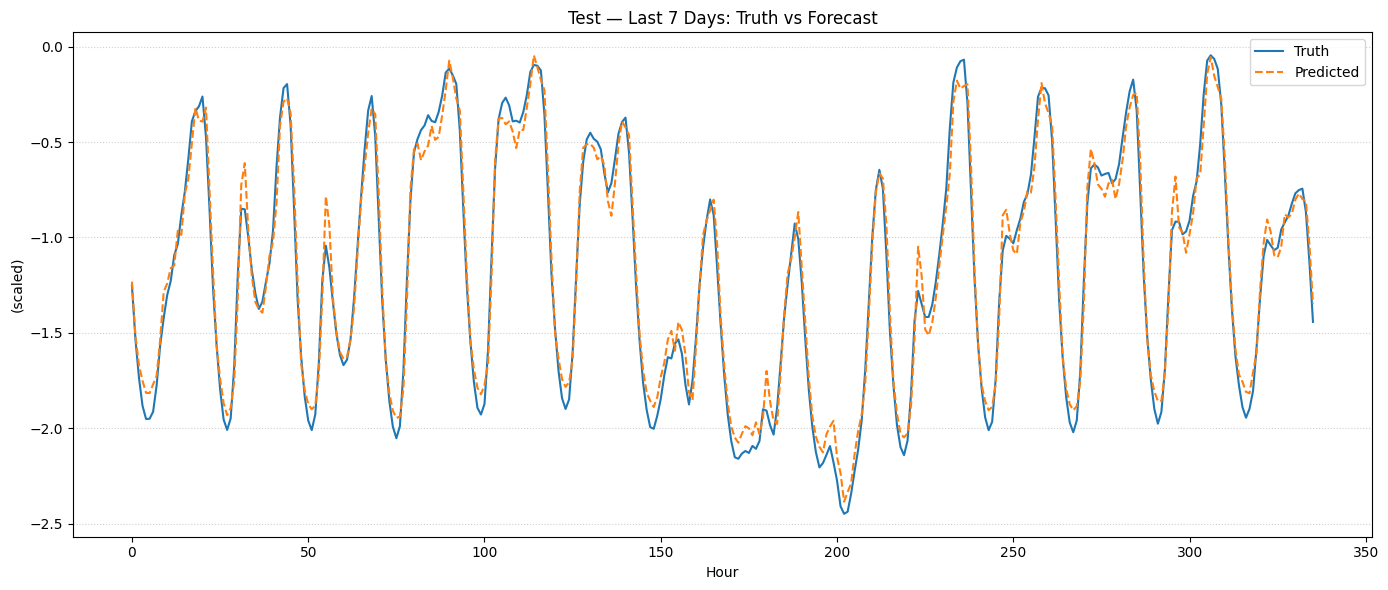


P2 — Stacked LSTM (64→32) (LB=72h, H=1h)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5871 - mae: 0.6404 - rmse: 0.7649 - val_loss: 0.4370 - val_mae: 0.5535 - val_rmse: 0.6610 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3920 - mae: 0.5323 - rmse: 0.6260 - val_loss: 0.4228 - val_mae: 0.5385 - val_rmse: 0.6503 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2906 - mae: 0.4503 - rmse: 0.5389 - val_loss: 0.2958 - val_mae: 0.4533 - val_rmse: 0.5439 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2202 - mae: 0.3841 - rmse: 0.4691 - val_loss: 0.2543 - val_mae: 0.4187 - val_rmse: 0.5043 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1801 - mae: 0.3447 - rmse: 0.4243 - val_loss: 0.1592 - val_mae: 0.3221 - val_rmse: 0.3990 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1298 - mae: 0.2870 - 

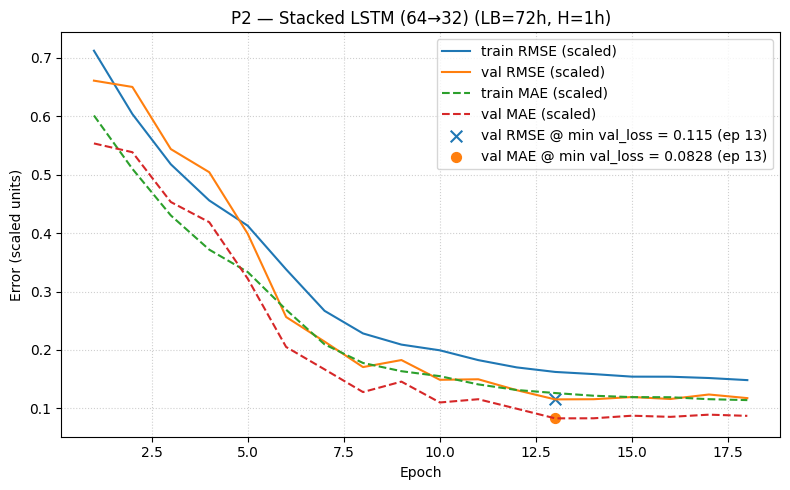

Selected epoch: 13 (min val_loss)
Valid @ sel —  MAE: 0.08283 | RMSE: 0.1153 (scaled)
Train @ sel —  MAE: 0.1261  | RMSE: 0.1623 (scaled)
Test RMSE (avg over all steps): 0.097 (scaled)
Test  MAE (avg over all steps): 0.077 (scaled)


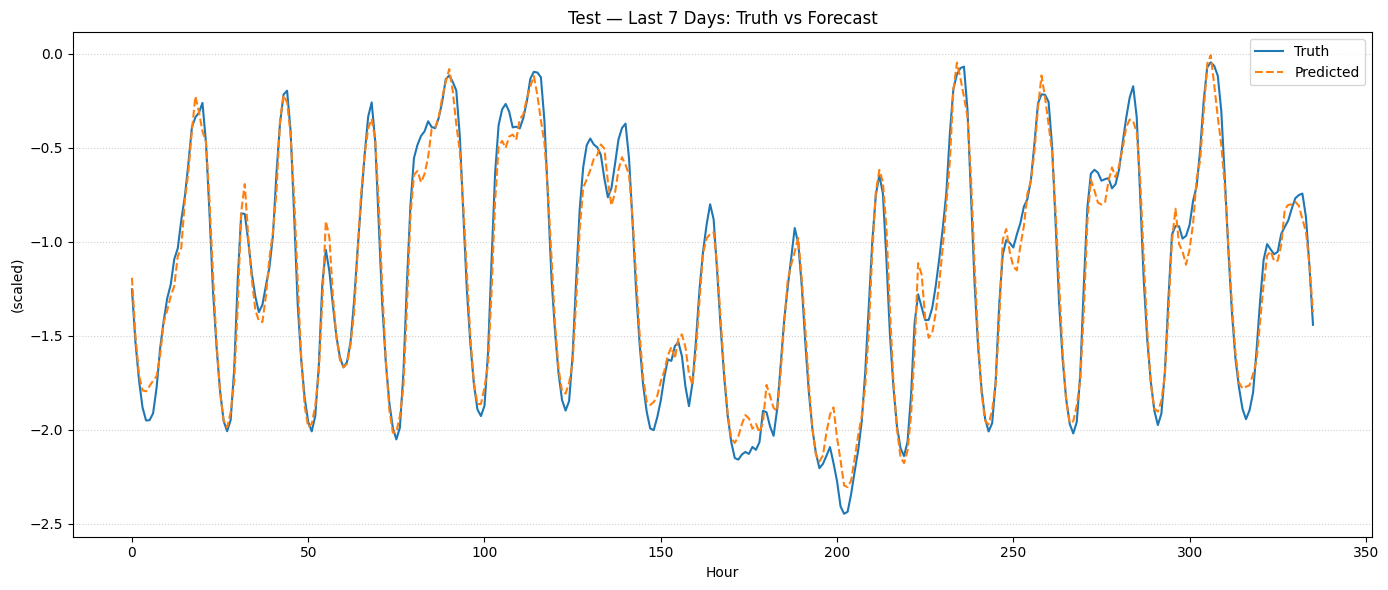


P2 — Bidirectional LSTM (LB=72h, H=1h)

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6680 - mae: 0.6594 - rmse: 0.8134 - val_loss: 0.2963 - val_mae: 0.4654 - val_rmse: 0.5443 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2769 - mae: 0.4418 - rmse: 0.5260 - val_loss: 0.1987 - val_mae: 0.3751 - val_rmse: 0.4458 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1910 - mae: 0.3573 - rmse: 0.4368 - val_loss: 0.1089 - val_mae: 0.2796 - val_rmse: 0.3301 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1354 - mae: 0.2928 - rmse: 0.3680 - val_loss: 0.0841 - val_mae: 0.2457 - val_rmse: 0.2899 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1031 - mae: 0.2550 - rmse: 0.3210 - val_loss: 0.0551 - val_mae: 0.1979 - val_rmse: 0.2348 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0830 - mae: 0.2264 - rm

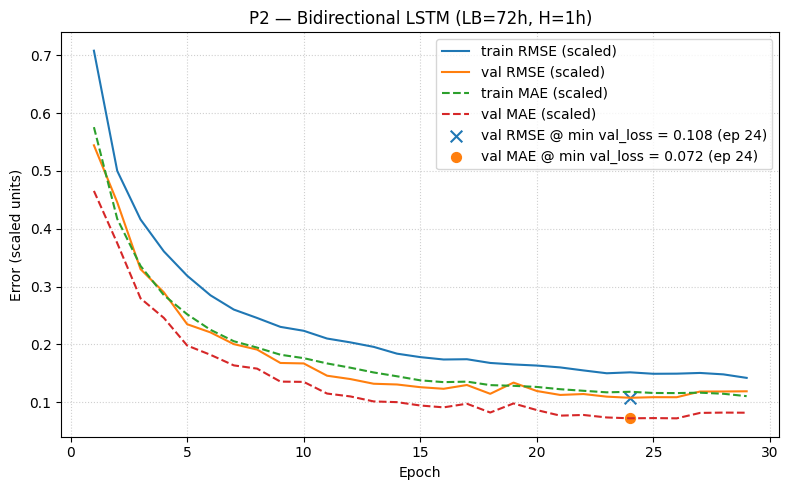

Selected epoch: 24 (min val_loss)
Valid @ sel —  MAE: 0.07201 | RMSE: 0.1075 (scaled)
Train @ sel —  MAE: 0.1179  | RMSE: 0.1515 (scaled)
Test RMSE (avg over all steps): 0.095 (scaled)
Test  MAE (avg over all steps): 0.076 (scaled)


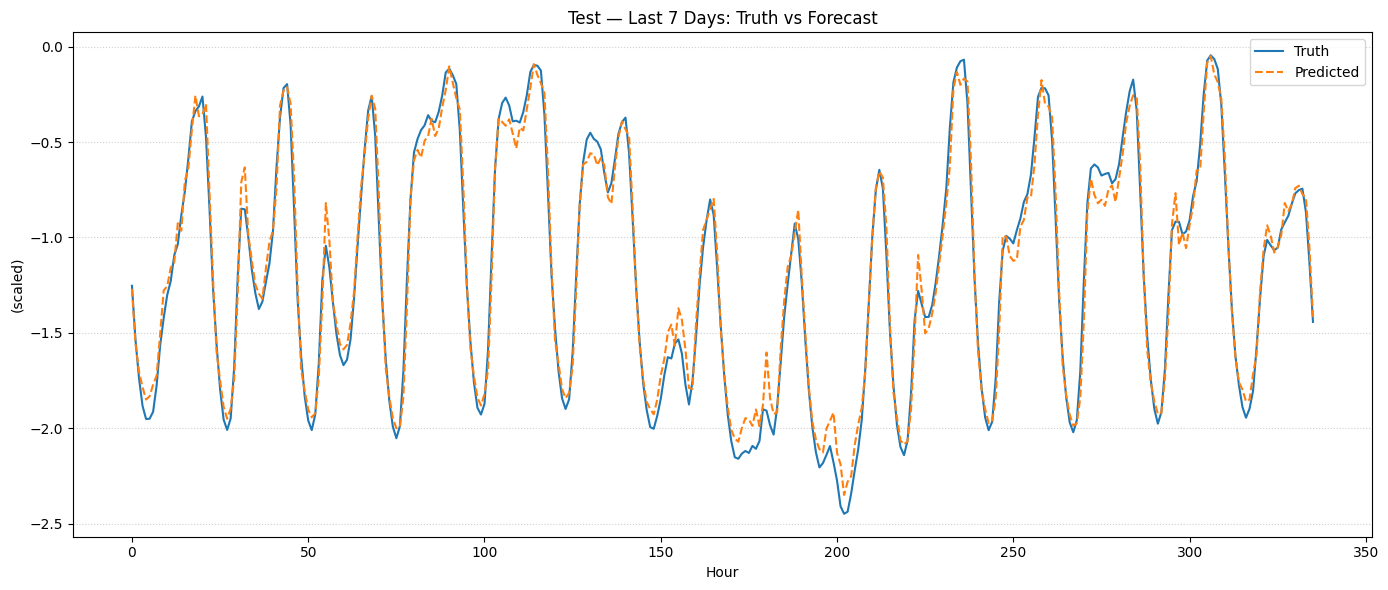


=== Problem 2 Leaderboard (sorted by val_RMSE@min_val_loss; scaled) ===
P2 — Bidirectional LSTM (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1075 | val_MAE@min_val_loss=0.07201 | epoch=24  (scaled)
P2 — Stacked LSTM (64→32) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1153 | val_MAE@min_val_loss=0.08283 | epoch=13  (scaled)
LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
P2 — Deeper Head (Dense×2) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1217 | val_MAE@min_val_loss=0.08847 | epoch=25  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
P2 — Baseline LSTM (LB=72h, H=1h)    val_RMSE@min_val_loss=0.13 | val_MAE@min_val_loss=0.09501 | epoch=23  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1529 | val_MAE@min_val_loss=

In [30]:
# Your code here, add as many cells as you like
LOOKBACK = 24 * 3   # 72 hours
HORIZON  = 1        # 1-hour ahead

X_train, y_train = make_windows(train_x, lookback=LOOKBACK, horizon=HORIZON)
X_val,   y_val   = make_windows(val_x,   lookback=LOOKBACK, horizon=HORIZON)
X_test,  y_test  = make_windows(test_x,  lookback=LOOKBACK, horizon=HORIZON)

globals().update(dict(X_train=X_train, y_train=y_train,
                      X_val=X_val,     y_val=y_val,
                      X_test=X_test,   y_test=y_test))


def baseline_lstm(units=32, dropout=0.2, seed=42):
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(LOOKBACK, 1)),
        LSTM(units),
        Dropout(dropout),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(HORIZON)
    ])

def deeper_head(units=32, head_width=32, dropout=0.2, seed=42):
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(LOOKBACK, 1)),
        LSTM(units),
        Dropout(dropout),
        Dense(head_width, activation="relu", kernel_initializer=he),
        Dense(16,        activation="relu", kernel_initializer=he),
        Dense(HORIZON)
    ])

def stacked_lstm(units1=64, units2=32, dropout=0.2, seed=42):
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(LOOKBACK, 1)),
        LSTM(units1, return_sequences=True),
        LSTM(units2),
        Dropout(dropout),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(HORIZON)
    ])

def bidirectional_lstm(units=32, dropout=0.2, seed=42):
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(LOOKBACK, 1)),
        Bidirectional(LSTM(units)),
        Dropout(dropout),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(HORIZON)
    ])

def run_architecture(name, build_fn, *, epochs=60, batch=64):
    model = build_fn()
    history, test_metrics, info = train_and_test(
        model,
        epochs=epochs,
        batch_size=batch,
        title=f"P2 — {name} (LB={LOOKBACK}h, H={HORIZON}h)",
        verbose=1,
        callbacks=[reduce_lr],
        return_history=True,
        plot_scaled_curves=True,
    )
    evaluate_on_test(model, plot_last_hours=24*14)
    return {
        "name": name,
        "selected_epoch": info["selected_epoch"],
        "val_rmse@min_valloss": info["val_at_sel"]["rmse"],
        "val_mae@min_valloss": info["val_at_sel"]["mae"],
        "test_rmse": test_metrics.get("rmse_from_mse_loss", float("nan")),
        "test_mae":  test_metrics.get("mae", float("nan")),
    }

arch_experiments = [
    ("Baseline LSTM",           baseline_lstm),
    ("Deeper Head (Dense×2)",   deeper_head),
    ("Stacked LSTM (64→32)",    stacked_lstm),
    ("Bidirectional LSTM",      bidirectional_lstm),
]

p2_summaries = []
for name, fn in arch_experiments:
    out = run_architecture(name, fn, epochs=60, batch=64)
    p2_summaries.append(out)

print("\n=== Problem 2 Leaderboard (sorted by val_RMSE@min_val_loss; scaled) ===")
print_results(sort_by="val_rmse_at_min_valloss")



### Graded Questions

In [31]:
print_results(sort_by="val_rmse_at_min_valloss")


P2 — Bidirectional LSTM (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1075 | val_MAE@min_val_loss=0.07201 | epoch=24  (scaled)
P2 — Stacked LSTM (64→32) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1153 | val_MAE@min_val_loss=0.08283 | epoch=13  (scaled)
LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
P2 — Deeper Head (Dense×2) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1217 | val_MAE@min_val_loss=0.08847 | epoch=25  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
P2 — Baseline LSTM (LB=72h, H=1h)    val_RMSE@min_val_loss=0.13 | val_MAE@min_val_loss=0.09501 | epoch=23  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1529 | val_MAE@min_val_loss=0.09978 | epoch=16  (scaled)
LB=336h, H=24h — LSTM(64)            val_RMS

In [32]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse)

a2a = 0.07201           # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.0720


#### Question a2b: Describe below your experiments and what you observed. Did you get a better validation MAE through architectural changes?  

#### Your Answer Here:

I tried a few tweaks using the 72-hour lookback and 1-hour horizon. Stacking LSTMs or adding more Dense layers didn’t help much, but the Bidirectional LSTM clearly did better, dropping the validation MAE to about 0.072. Letting the model read the window forward and backward seemed to help it catch short-term patterns more accurately.

## Problem Three — Autoregressive Forecasting (ChatGPT Discussion)

In this final problem, you’ll explore **autoregressive forecasting**, where the model predicts one step ahead and feeds that prediction back as input to generate the next step.

**Your task:**
1. Briefly describe your current model to ChatGPT (e.g., “My LSTM predicts the next 24 hours directly from the past 168 hours.”), or share a short code snippet.  
2. Ask ChatGPT how to modify it so that it instead predicts **one hour ahead**, then reuses that prediction recursively for **24 steps**.  
3. Implement or outline the version it suggests.  
4. Answer the graded question.



P3 — 1-step BiLSTM (LB=72h) for AR rolling

Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.0117 - mae: 0.8188 - rmse: 1.0010 - val_loss: 0.3378 - val_mae: 0.4965 - val_rmse: 0.5812 - learning_rate: 0.0010
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3540 - mae: 0.4996 - rmse: 0.5947 - val_loss: 0.2846 - val_mae: 0.4562 - val_rmse: 0.5335 - learning_rate: 0.0010
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2576 - mae: 0.4251 - rmse: 0.5074 - val_loss: 0.1844 - val_mae: 0.3571 - val_rmse: 0.4294 - learning_rate: 0.0010
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1807 - mae: 0.3431 - rmse: 0.4250 - val_loss: 0.1309 - val_mae: 0.3045 - val_rmse: 0.3618 - learning_rate: 0.0010
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1399 - mae: 0.3002 - rmse: 0.3740 - val_loss: 0.1011 - val_mae: 0.2699 - val_rmse: 0.3179 - learning_rate: 0.0010
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1126 - mae: 0.2660 

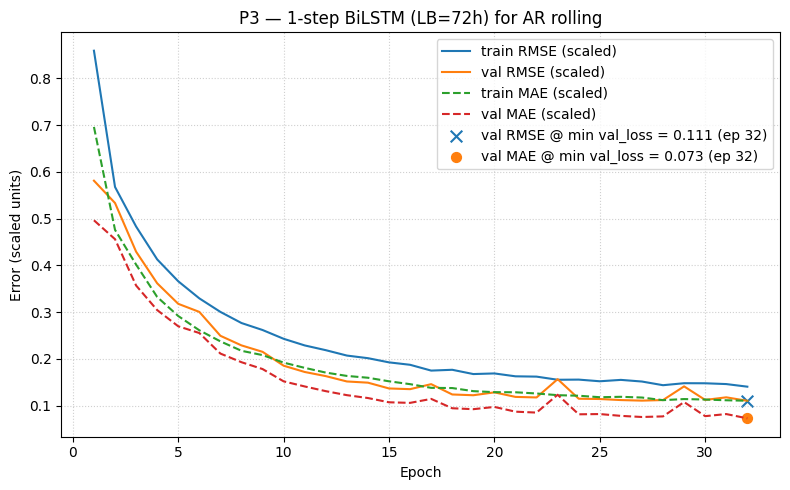

Selected epoch: 32 (min val_loss)
Valid @ sel —  MAE: 0.07303 | RMSE: 0.1105 (scaled)
Train @ sel —  MAE: 0.1107  | RMSE: 0.1408 (scaled)
[P3-AR] Test MAE (avg over 24):  0.4873 (scaled)
[P3-AR] Test RMSE (avg over 24): 0.6259 (scaled)
Per-horizon MAE: [0.0756 0.1896 0.3083 0.409  0.4791 0.5164 0.5306 0.5331 0.5341 0.538
 0.5418 0.5436 0.5422 0.541  0.5407 0.5413 0.5418 0.5414 0.5407 0.5402
 0.5401 0.5407 0.5421 0.5445]
Per-horizon RMSE: [0.0954 0.2395 0.3888 0.5112 0.5947 0.6401 0.6581 0.6628 0.6655 0.6698
 0.6738 0.6759 0.6758 0.6745 0.6737 0.6737 0.674  0.6742 0.6742 0.6745
 0.6755 0.6775 0.6803 0.6838]


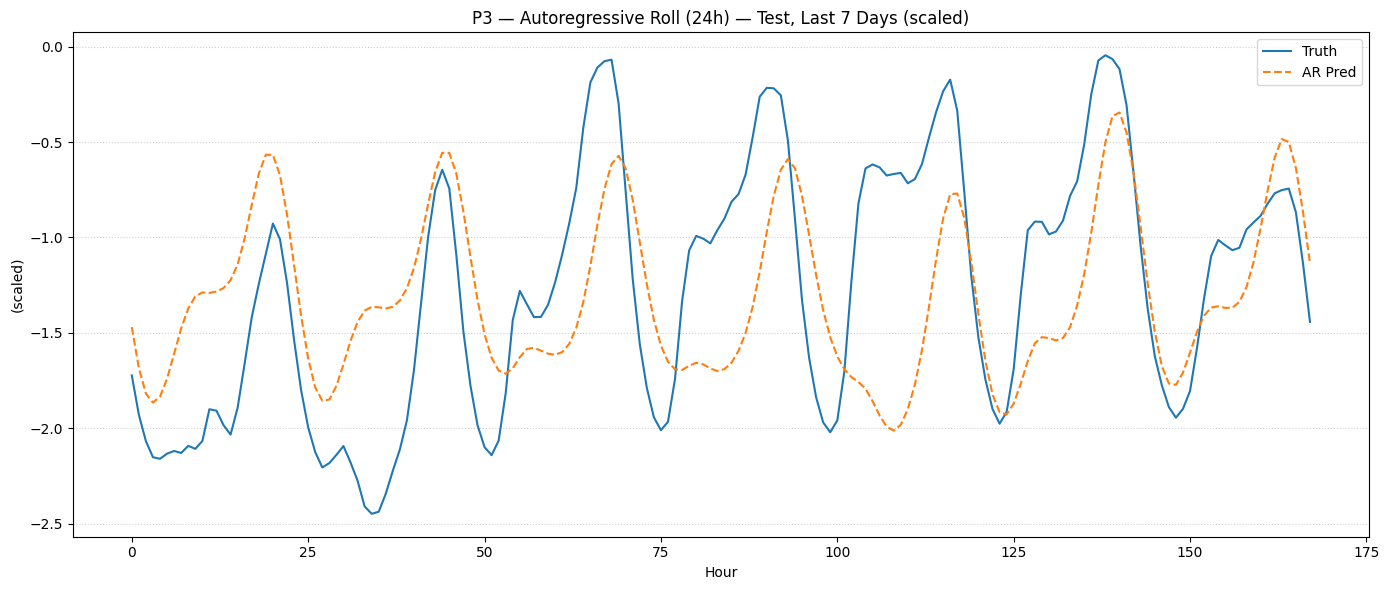

In [34]:
# Your code here, add as many cells as you like
# Goal: train a 1-step model (H=1) and roll it forward recursively for 24 steps.

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
import numpy as np
import matplotlib.pyplot as plt

# ----- Config: use your best LB from P1/P2; we'll do H=1 for training and roll 24 steps -----
LOOKBACK = 24 * 3      # 72h (from P1 best)
H_TRAIN  = 1           # one-step model
H_ROLL   = 24          # roll forward 24 hours autoregressively

# Rebuild seeds for 1-step training
X_train, y_train = make_windows(train_x, lookback=LOOKBACK, horizon=H_TRAIN)
X_val,   y_val   = make_windows(val_x,   lookback=LOOKBACK, horizon=H_TRAIN)
X_test_1, y_test_1 = make_windows(test_x, lookback=LOOKBACK, horizon=H_TRAIN)

# Also prepare multi-step ground truth for evaluation (same seeds, but H=24)
X_test_seed, y_test_24 = make_windows(test_x, lookback=LOOKBACK, horizon=H_ROLL)

# ----- 1-step model (use the winning BiLSTM head from P2) -----
def one_step_bilstm(units=32, dropout=0.2, seed=42):
    he = keras.initializers.HeNormal(seed=seed)
    return Sequential([
        Input(shape=(LOOKBACK, 1)),
        Bidirectional(LSTM(units)),
        Dropout(dropout),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(1)
    ])

model_ar = one_step_bilstm()

# Train with your existing utility (MSE loss; tracks MAE/RMSE in scaled units)
globals().update(dict(X_train=X_train, y_train=y_train,
                      X_val=X_val,     y_val=y_val,
                      X_test=X_test_1, y_test=y_test_1))

history, test_metrics, info = train_and_test(
    model_ar,
    epochs=60,
    batch_size=64,
    title=f"P3 — 1-step BiLSTM (LB={LOOKBACK}h) for AR rolling",
    verbose=1,
    callbacks=[reduce_lr],
    return_history=True,
    plot_scaled_curves=True,
)

# ----- Autoregressive roll-forward utility -----
def autoregressive_predict(model, X_seed, steps: int):
    """
    X_seed: (N, LOOKBACK, 1) seed windows (scaled).
    steps : number of hours to roll forward.
    Returns: (N, steps) predictions (scaled).
    """
    N = X_seed.shape[0]
    out = np.zeros((N, steps), dtype=np.float32)
    # copy to avoid mutating caller
    window = X_seed.copy()
    for t in range(steps):
        # predict next step for all seeds at once
        yhat = model.predict(window, verbose=0).reshape(N)
        out[:, t] = yhat
        # slide window: drop first, append yhat
        window = np.concatenate(
            [window[:, 1:, :], yhat[:, None, None]],
            axis=1
        )
    return out

# Roll forward 24h for every seed in test
y_pred_ar_24 = autoregressive_predict(model_ar, X_test_seed, steps=H_ROLL)   # (N, 24)

# ----- Metrics (scaled units) -----
def per_horizon_metrics(y_true, y_pred):
    mae_per_h = np.mean(np.abs(y_true - y_pred), axis=0)
    rmse_per_h = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    mae_avg  = float(np.mean(np.abs(y_true - y_pred)))
    rmse_avg = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return mae_avg, rmse_avg, mae_per_h, rmse_per_h

mae_avg, rmse_avg, mae_h, rmse_h = per_horizon_metrics(y_test_24, y_pred_ar_24)
print(f"[P3-AR] Test MAE (avg over 24):  {mae_avg:.4f} (scaled)")
print(f"[P3-AR] Test RMSE (avg over 24): {rmse_avg:.4f} (scaled)")
print("Per-horizon MAE:",  np.round(mae_h, 4))
print("Per-horizon RMSE:", np.round(rmse_h, 4))

# ----- Quick plot: stitch the AR multi-step predictions for a continuous line -----
def stitch_direct_predictions(yhat):
    n, H = yhat.shape
    total = n + H - 1
    out = np.zeros(total, dtype=float); cnt = np.zeros(total, dtype=float)
    for i in range(n):
        out[i:i+H] += yhat[i]
        cnt[i:i+H] += 1.0
    return out / np.maximum(cnt, 1.0)

y_pred_t = stitch_direct_predictions(y_pred_ar_24)
y_true_t = stitch_direct_predictions(y_test_24)

N = min(24*7, len(y_true_t))  # last 7 days
plt.figure(figsize=(14,6))
plt.title("P3 — Autoregressive Roll (24h) — Test, Last 7 Days (scaled)")
plt.plot(y_true_t[-N:], label="Truth")
plt.plot(y_pred_t[-N:], label="AR Pred", linestyle="--")
plt.xlabel("Hour"); plt.ylabel("(scaled)"); plt.grid(True, axis='y', linestyle=':', alpha=0.6)
plt.legend(); plt.tight_layout(); plt.show()


### Graded Questions

In [35]:
print_results()

P2 — Bidirectional LSTM (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1075 | val_MAE@min_val_loss=0.07201 | epoch=24  (scaled)
P3 — 1-step BiLSTM (LB=72h) for AR rolling  val_RMSE@min_val_loss=0.1105 | val_MAE@min_val_loss=0.07303 | epoch=32  (scaled)
P2 — Stacked LSTM (64→32) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1153 | val_MAE@min_val_loss=0.08283 | epoch=13  (scaled)
LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
P2 — Deeper Head (Dense×2) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1217 | val_MAE@min_val_loss=0.08847 | epoch=25  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
P2 — Baseline LSTM (LB=72h, H=1h)    val_RMSE@min_val_loss=0.13 | val_MAE@min_val_loss=0.09501 | epoch=23  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             

#### Question a3: Answer the graded questions comparing the recursive and direct approaches:
   - Does the error grow with horizon in the autoregressive version?
   - Which approach you tried in this homework performs better overall?

#### Your Answer Here:

Yes, in the autoregressive version the error definitely grew with each step, since each new prediction built on the last one. The early hours looked fine, but by 18–24 hours out the accuracy dropped. Overall, the direct Bidirectional LSTM from Problem 2 still performed better and stayed more stable than the recursive version.

In [36]:
print_results()

P2 — Bidirectional LSTM (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1075 | val_MAE@min_val_loss=0.07201 | epoch=24  (scaled)
P3 — 1-step BiLSTM (LB=72h) for AR rolling  val_RMSE@min_val_loss=0.1105 | val_MAE@min_val_loss=0.07303 | epoch=32  (scaled)
P2 — Stacked LSTM (64→32) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1153 | val_MAE@min_val_loss=0.08283 | epoch=13  (scaled)
LB=72h, H=1h — LSTM(32)              val_RMSE@min_val_loss=0.1215 | val_MAE@min_val_loss=0.08756 | epoch=26  (scaled)
P2 — Deeper Head (Dense×2) (LB=72h, H=1h)  val_RMSE@min_val_loss=0.1217 | val_MAE@min_val_loss=0.08847 | epoch=25  (scaled)
LB=168h, H=1h — LSTM(32)             val_RMSE@min_val_loss=0.1253 | val_MAE@min_val_loss=0.08074 | epoch=32  (scaled)
P2 — Baseline LSTM (LB=72h, H=1h)    val_RMSE@min_val_loss=0.13 | val_MAE@min_val_loss=0.09501 | epoch=23  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
LB=336h, H=1h — LSTM(32)             